# Gauge Observables

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = 5 * ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = 5 * ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'P', 'D']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

In [2]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [6]:
from lattice.lattice import GaugeLattice, u1_plaq_exact
#from l2hmc_eager import gauge_dynamics_eager as gde
from gauge_model import GaugeModel, save_params_to_pkl_file

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib inline

In [7]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [8]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Calculate and plot observables...

### Calculate observables for samples generated during **_training_**:
- Every $\approx 500$ steps or so during training procedure, we run the sampler at $\beta \equiv \beta_{\mathrm{final}}$. 
- By calculating observables (``total action``, ``average plaquette``, and ``topological charge``) for these samples and looking at the ``thermalization time``, we can get an idea of how well the sampler is performing.
- We expect that as the training procedure continues, the ``thermalization time`` should decrease as the sampler improves.

In [20]:
# 53.3s
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_227')
train_observables_dicts = calc_observables(log_dir,
                                           observables_dicts=None,
                                           training=True,
                                           frac=None)

Calculating observables for 1000...
step: 0 / 500 training steps: 1000 beta:  4  time/step: 0.003089 avg action: 39.61  exact plaquette: 0.8635 avg plaquette: 0.3811 


top_charges: [-2.  0.  1.  1. -3.  0.]


step: 10 / 500 training steps: 1000 beta:  4  time/step: 0.003094 avg action: 17.81  exact plaquette: 0.8635 avg plaquette: 0.7217 


top_charges: [ 1.  0.  1.  2. -1.  1.]


step: 20 / 500 training steps: 1000 beta:  4  time/step: 0.002845 avg action: 14.34  exact plaquette: 0.8635 avg plaquette: 0.7759 


top_charges: [ 0.  0.  1.  1. -2.  2.]


step: 30 / 500 training steps: 1000 beta:  4  time/step: 0.003663 avg action:  11.6  exact plaquette: 0.8635 avg plaquette: 0.8187 


top_charges: [ 1.  0.  2.  2. -1.  2.]


step: 40 / 500 training steps: 1000 beta:  4  time/step: 0.00292 avg action: 11.45  exact plaquette: 0.8635 avg plaquette: 0.8211 


top_charges: [ 0.  0.  1.  1. -2.  0.]


step: 50 / 500 training steps: 1000 beta:  4  time/step: 0.003028 avg action: 10.96  exact 

step: 480 / 500 training steps: 1000 beta:  4  time/step: 0.02626 avg action: 10.81  exact plaquette: 0.8635 avg plaquette: 0.8311 


top_charges: [ 0.  0.  1.  1. -2.  1.]


step: 490 / 500 training steps: 1000 beta:  4  time/step: 0.003321 avg action: 9.884  exact plaquette: 0.8635 avg plaquette: 0.8456 


top_charges: [ 0.  0.  1.  1. -2.  1.]


----------------------------------------------------------------------------------------

Average plaquette statistics for sample 0, consisting of 500 L2HMC steps, at beta = 4.0.
< plaquette >: 0.8443082565069199
jackknife estimate of < plaquette >: 0.8443082565069199
bias: 0.0
stderr: 0.0014245936800400243
conf_interval: [0.8415161  0.84710041]

----------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------

Average plaquette statistics for sample 1, consisting of 500 L2HMC steps, at beta = 4.0.
< plaquette >: 0.86886248517036

step: 140 / 500 training steps: 2000 beta:  4  time/step: 0.004086 avg action: 9.419  exact plaquette: 0.8635 avg plaquette: 0.8528 


top_charges: [ 0. -1.  2.  1.  0.  0.]


step: 150 / 500 training steps: 2000 beta:  4  time/step: 0.007543 avg action: 9.492  exact plaquette: 0.8635 avg plaquette: 0.8517 


top_charges: [0. 0. 3. 1. 0. 0.]


step: 160 / 500 training steps: 2000 beta:  4  time/step: 0.004971 avg action: 9.514  exact plaquette: 0.8635 avg plaquette: 0.8513 


top_charges: [ 0. -1.  3.  1.  0.  0.]


step: 170 / 500 training steps: 2000 beta:  4  time/step: 0.002718 avg action: 10.12  exact plaquette: 0.8635 avg plaquette: 0.8418 


top_charges: [-1. -1.  3.  1.  0.  0.]


step: 180 / 500 training steps: 2000 beta:  4  time/step: 0.002569 avg action: 10.24  exact plaquette: 0.8635 avg plaquette:  0.84  


top_charges: [0. 0. 3. 0. 0. 0.]


step: 190 / 500 training steps: 2000 beta:  4  time/step: 0.00457 avg action: 8.525  exact plaquette: 0.8635 avg plaquette: 0.8668 


----------------------------------------------------------------------------------------

Average plaquette statistics for sample 5, consisting of 500 L2HMC steps, at beta = 4.0.
< plaquette >: 0.8477366048693656
jackknife estimate of < plaquette >: 0.8477366048693656
bias: 0.0
stderr: 0.002134394378484581
conf_interval: [0.84355327 0.85191994]

----------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------

Topological susceptibility statistics for sample 0, consisting of 500 L2HMC steps, at beta = 4.0.
< Q >: -0.474
< Q^2 >: 0.534
jackknife estimate of < Q^2 >: 0.534
bias: 0.0
stderr: 0.040657028764728424
conf_interval: [0.45431369 0.61368631]

-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------

Topological susceptibi

step: 300 / 500 training steps: 3000 beta:  4  time/step: 0.002157 avg action: 7.665  exact plaquette: 0.8635 avg plaquette: 0.8802 


top_charges: [ 0.  1. -1.  0.  0. -1.]


step: 310 / 500 training steps: 3000 beta:  4  time/step: 0.002961 avg action: 8.953  exact plaquette: 0.8635 avg plaquette: 0.8601 


top_charges: [ 0.  1. -1.  1.  1.  0.]


step: 320 / 500 training steps: 3000 beta:  4  time/step: 0.002385 avg action: 9.048  exact plaquette: 0.8635 avg plaquette: 0.8586 


top_charges: [-1.  1.  0.  1.  1.  0.]


step: 330 / 500 training steps: 3000 beta:  4  time/step: 0.002897 avg action: 10.44  exact plaquette: 0.8635 avg plaquette: 0.8369 


top_charges: [-1.  0.  0.  1.  1. -1.]


step: 340 / 500 training steps: 3000 beta:  4  time/step: 0.001738 avg action: 9.641  exact plaquette: 0.8635 avg plaquette: 0.8494 


top_charges: [-1.  1. -1.  0.  0. -1.]


step: 350 / 500 training steps: 3000 beta:  4  time/step: 0.002658 avg action: 8.821  exact plaquette: 0.8635 avg plaque

-------------------------------------------------------------------------------------------------

Topological susceptibility statistics for sample 5, consisting of 500 L2HMC steps, at beta = 4.0.
< Q >: -0.598
< Q^2 >: 0.662
jackknife estimate of < Q^2 >: 0.662
bias: 0.0
stderr: 0.03690848781711186
conf_interval: [0.58966069 0.73433931]

-------------------------------------------------------------------------------------------------

Saving actions to: ../../gauge_logs_graph/run_227/observables/training/1000_steps_beta_4.0/actions_1000_beta_4.0.pkl.
Saving plaquettes to: ../../gauge_logs_graph/run_227/observables/training/1000_steps_beta_4.0/plaqs_1000_beta_4.0.pkl.
Saving top. charges to: ../../gauge_logs_graph/run_227/observables/training/1000_steps_beta_4.0/charges_1000_beta_4.0.pkl.
Saving suscept. stats to: ../../gauge_logs_graph/run_227/observables/training/1000_steps_beta_4.0/susceptibility_stats_1000_beta_4.0.pkl.
Saving plaquettes stats. to: ../../gauge_logs_graph/run_227/ob

####  **Update train_observables_dicts:**  
 * If `observables_dicts` argument of `calc_training_observables` is not `None`, only calculate observables that haven't been previously calculated.  

In [21]:
train_observables_dicts = calc_observables(
    log_dir, 
    observables_dicts=train_observables_dicts,
    training=True,
)

Making directory: ../../gauge_logs_graph/run_227/figures/training/4000_train_steps_beta_4.0.
Observables alredy calculated for 1000 eval steps.
Observables alredy calculated for 2000 eval steps.
Observables alredy calculated for 3000 eval steps.
Calculating observables for 4000...
step: 0 / 500 training steps: 4000 beta:  4  time/step: 0.004085 avg action: 39.86  exact plaquette: 0.8635 avg plaquette: 0.3773 


top_charges: [ 0. -1. -1. -3.  1.  0.]


step: 10 / 500 training steps: 4000 beta:  4  time/step: 0.002883 avg action: 25.87  exact plaquette: 0.8635 avg plaquette: 0.5958 


top_charges: [ 0. -1. -1. -4.  5.  0.]


step: 20 / 500 training steps: 4000 beta:  4  time/step: 0.00261 avg action: 19.82  exact plaquette: 0.8635 avg plaquette: 0.6903 


top_charges: [ 2.  0. -1. -3.  2.  0.]


step: 30 / 500 training steps: 4000 beta:  4  time/step: 0.004376 avg action: 16.82  exact plaquette: 0.8635 avg plaquette: 0.7373 


top_charges: [ 1. -1.  0. -3.  1.  0.]


step: 40 / 500 train

step: 460 / 500 training steps: 4000 beta:  4  time/step: 0.002586 avg action: 7.975  exact plaquette: 0.8635 avg plaquette: 0.8754 


top_charges: [ 0.  0.  0. -2.  1.  0.]


step: 470 / 500 training steps: 4000 beta:  4  time/step: 0.002748 avg action: 9.471  exact plaquette: 0.8635 avg plaquette: 0.852  


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 480 / 500 training steps: 4000 beta:  4  time/step: 0.002675 avg action: 8.484  exact plaquette: 0.8635 avg plaquette: 0.8674 


top_charges: [ 0. -1.  0. -1.  0. -1.]


step: 490 / 500 training steps: 4000 beta:  4  time/step: 0.002679 avg action: 8.943  exact plaquette: 0.8635 avg plaquette: 0.8603 


top_charges: [ 0.  0.  0. -1.  1. -1.]


----------------------------------------------------------------------------------------

Average plaquette statistics for sample 0, consisting of 375 L2HMC steps, at beta = 4.0.
< plaquette >: 0.8665143102010091
jackknife estimate of < plaquette >: 0.8665143102010091
bias: 0.0
stderr: 0.0010984

Saving actions to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/actions_3000_beta_4.0.pkl.
Saving plaquettes to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/plaqs_3000_beta_4.0.pkl.
Saving top. charges to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/charges_3000_beta_4.0.pkl.
Saving suscept. stats to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/susceptibility_stats_3000_beta_4.0.pkl.
Saving plaquettes stats. to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/plaquettes_stats_3000_beta_4.0.pkl.
Saving charges probabilities to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/charges_probabilities_3000_beta_4.0.pkl.
Writing statistics to: ../../gauge_logs_graph/run_227/observables/training/3000_steps_beta_4.0/statistics_3000_beta_4.0.txt
---------------------------------------------------------------------------------------------
T

#### **Plot observables for samples generated during training:**
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [22]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=True)

Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_227/figures/training/3000_train_steps_beta_4.0/topological_charg

In [23]:
plot_top_charges(log_dir, train_observables_dicts[2], training=True)

Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/topological_charge_history_sample_0

In [24]:
plt.close('all')
plot_top_charges_counts(log_dir, 
                        train_observables_dicts[2], 
                        training=True)

Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
S

Making directory: ../../gauge_logs_graph/run_227/figures/training/5000_train_steps_beta_4.0.
Making directory: ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charges_counts
Saving figure to ../../gauge_logs_graph/run_227/figures/training/1000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_1000_steps_beta_4.0.pdf.
Making directory: ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/topological_charges_counts
Saving figure to ../../gauge_logs_graph/run_227/figures/training/2000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_2000_steps_beta_4.0.pdf.
Making directory: ../../gauge_logs_graph/run_227/figures/training/3000_train_steps_beta_4.0/topological_charges_counts
Saving figure to ../../gauge_logs_graph/run_227/figures/training/3000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_3000_steps_beta_4.0.pdf.
Making directory: ../../g

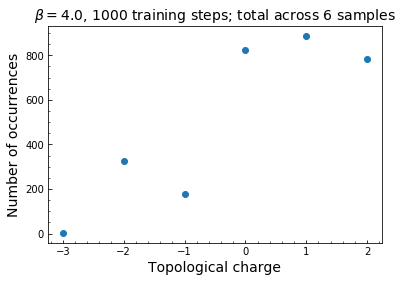

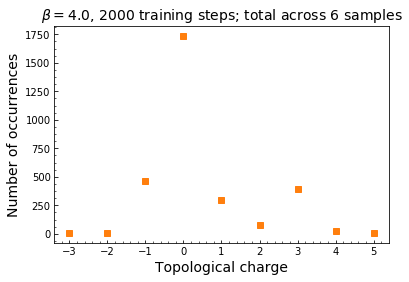

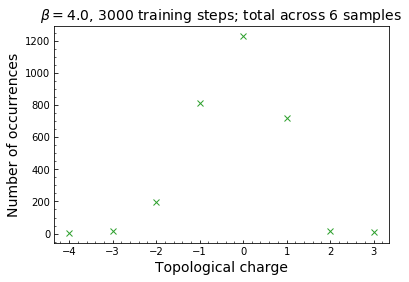

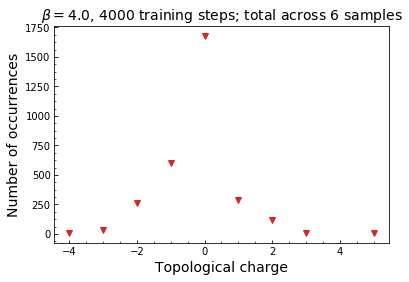

In [25]:
train_charges_dict = train_observables_dicts[2]
params, _, _, _, figs_dir_dict = find_samples(log_dir, training=True)
title_str_key = 'training'
count_dict = {}
idx = 0
for key, val in train_charges_dict.items():
    step, beta = key
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='')
                #fillstyle='none')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} {title_str_key} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=14)
    out_dir = os.path.join(
        figs_dir_dict[key], 'topological_charges_counts'
    )
    check_else_make_dir(out_dir)
    out_file = os.path.join(
        out_dir,
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [26]:
plt.close('all')

### Calculate observables for samples generated **_after_** training.
 - Again, samples are generated at $\beta = \beta_{\mathrm{final}}$.
 - In contrast to the samples generated **_during_** training (which are all ran for $\sim 100$ steps), we now look at generating longer chains (i.e. longer runs).

In [ ]:
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_227')
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=None, 
                                     training=False,
                                     frac=4)

Calculating observables for 50000...
step: 0 / 50000 beta:  3  time/step: 0.006011 avg action: 47.72  exact plaquette:  0.81  avg plaquette: 0.2543 


top_charges: [-1. -5.  0.  0.  0.  2.]


step: 10 / 50000 beta:  3  time/step: 0.003215 avg action:  34.1  exact plaquette:  0.81  avg plaquette: 0.4672 


top_charges: [ 0. -6. -1.  0. -4.  0.]


step: 20 / 50000 beta:  3  time/step: 0.004982 avg action: 30.42  exact plaquette:  0.81  avg plaquette: 0.5247 


top_charges: [ 0. -6. -1. -2. -1.  0.]


step: 30 / 50000 beta:  3  time/step: 0.001939 avg action: 27.41  exact plaquette:  0.81  avg plaquette: 0.5718 


top_charges: [ 0. -4.  0.  0. -1. -1.]


step: 40 / 50000 beta:  3  time/step: 0.00262 avg action: 22.94  exact plaquette:  0.81  avg plaquette: 0.6416 


top_charges: [ 0. -3.  0. -2. -1. -1.]


step: 50 / 50000 beta:  3  time/step: 0.005003 avg action: 19.17  exact plaquette:  0.81  avg plaquette: 0.7005 


top_charges: [ 0. -1. -1. -2. -3. -1.]


step: 60 / 50000 beta:  3  ti

step: 530 / 50000 beta:  3  time/step: 0.004875 avg action: 11.35  exact plaquette:  0.81  avg plaquette: 0.8226 


top_charges: [ 1.  0. -1. -1.  0. -1.]


step: 540 / 50000 beta:  3  time/step: 0.002358 avg action: 11.86  exact plaquette:  0.81  avg plaquette: 0.8146 


top_charges: [ 0.  0. -1.  0.  0. -1.]


step: 550 / 50000 beta:  3  time/step: 0.00217 avg action: 11.91  exact plaquette:  0.81  avg plaquette: 0.8139 


top_charges: [ 1.  0. -1. -2.  0.  0.]


step: 560 / 50000 beta:  3  time/step: 0.003013 avg action: 11.36  exact plaquette:  0.81  avg plaquette: 0.8225 


top_charges: [ 0.  0.  0. -2.  0.  0.]


step: 570 / 50000 beta:  3  time/step: 0.006123 avg action: 12.17  exact plaquette:  0.81  avg plaquette: 0.8099 


top_charges: [ 1.  0. -1. -2.  0.  0.]


step: 580 / 50000 beta:  3  time/step: 0.002107 avg action: 14.15  exact plaquette:  0.81  avg plaquette: 0.779  


top_charges: [ 0.  0.  0. -2.  0. -1.]


step: 590 / 50000 beta:  3  time/step: 0.003129 avg action:

top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 1060 / 50000 beta:  3  time/step: 0.00186 avg action: 12.52  exact plaquette:  0.81  avg plaquette: 0.8044 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 1070 / 50000 beta:  3  time/step: 0.004198 avg action:  12.6  exact plaquette:  0.81  avg plaquette: 0.8032 


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 1080 / 50000 beta:  3  time/step: 0.003299 avg action: 14.43  exact plaquette:  0.81  avg plaquette: 0.7746 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 1090 / 50000 beta:  3  time/step: 0.001445 avg action: 12.14  exact plaquette:  0.81  avg plaquette: 0.8103 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 1100 / 50000 beta:  3  time/step: 0.004689 avg action: 12.64  exact plaquette:  0.81  avg plaquette: 0.8025 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 1110 / 50000 beta:  3  time/step: 0.004815 avg action: 11.77  exact plaquette:  0.81  avg plaquette: 0.8162 


top_charges: [ 0. -1.  0.  0.  0. -1.]


step: 1120 / 50000

step: 1600 / 50000 beta:  3  time/step: 0.004471 avg action: 11.42  exact plaquette:  0.81  avg plaquette: 0.8216 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 1610 / 50000 beta:  3  time/step: 0.02334 avg action: 12.27  exact plaquette:  0.81  avg plaquette: 0.8083 


top_charges: [ 0. -1.  0.  0.  0. -1.]


step: 1620 / 50000 beta:  3  time/step: 0.01434 avg action:  11.5  exact plaquette:  0.81  avg plaquette: 0.8204 


top_charges: [ 0. -1. -1.  0.  0. -1.]


step: 1630 / 50000 beta:  3  time/step: 0.001956 avg action: 12.91  exact plaquette:  0.81  avg plaquette: 0.7983 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 1640 / 50000 beta:  3  time/step: 0.006156 avg action:  11.4  exact plaquette:  0.81  avg plaquette: 0.8219 


top_charges: [ 0. -1. -1.  0.  0. -1.]


step: 1650 / 50000 beta:  3  time/step: 0.01432 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8131 


top_charges: [ 0. -1. -1.  0.  0. -1.]


step: 1660 / 50000 beta:  3  time/step: 0.002288 avg action: 

step: 2140 / 50000 beta:  3  time/step: 0.003967 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [ 0.  0.  0. -1. -1.  0.]


step: 2150 / 50000 beta:  3  time/step: 0.004352 avg action: 12.52  exact plaquette:  0.81  avg plaquette: 0.8045 


top_charges: [ 0.  0.  1.  0. -1.  0.]


step: 2160 / 50000 beta:  3  time/step: 0.006711 avg action: 13.55  exact plaquette:  0.81  avg plaquette: 0.7882 


top_charges: [ 1.  0.  1.  0. -1.  0.]


step: 2170 / 50000 beta:  3  time/step: 0.006792 avg action: 12.69  exact plaquette:  0.81  avg plaquette: 0.8017 


top_charges: [ 0.  0.  1.  0. -1.  0.]


step: 2180 / 50000 beta:  3  time/step: 0.002906 avg action:  12.4  exact plaquette:  0.81  avg plaquette: 0.8063 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 2190 / 50000 beta:  3  time/step: 0.001835 avg action: 12.64  exact plaquette:  0.81  avg plaquette: 0.8026 


top_charges: [1. 0. 1. 0. 0. 0.]


step: 2200 / 50000 beta:  3  time/step: 0.002383 avg action:   1

step: 2690 / 50000 beta:  3  time/step: 0.002703 avg action: 10.62  exact plaquette:  0.81  avg plaquette: 0.8341 


top_charges: [0. 0. 1. 1. 0. 1.]


step: 2700 / 50000 beta:  3  time/step: 0.001887 avg action: 11.55  exact plaquette:  0.81  avg plaquette: 0.8195 


top_charges: [0. 1. 1. 1. 0. 0.]


step: 2710 / 50000 beta:  3  time/step: 0.00206 avg action: 12.24  exact plaquette:  0.81  avg plaquette: 0.8088 


top_charges: [ 0.  1.  0.  1. -1.  1.]


step: 2720 / 50000 beta:  3  time/step: 0.002268 avg action: 13.63  exact plaquette:  0.81  avg plaquette: 0.7871 


top_charges: [0. 1. 0. 0. 0. 1.]


step: 2730 / 50000 beta:  3  time/step: 0.006077 avg action: 14.21  exact plaquette:  0.81  avg plaquette: 0.7779 


top_charges: [ 0.  1.  0.  1. -1.  0.]


step: 2740 / 50000 beta:  3  time/step: 0.002838 avg action: 12.77  exact plaquette:  0.81  avg plaquette: 0.8004 


top_charges: [0. 1. 1. 0. 0. 0.]


step: 2750 / 50000 beta:  3  time/step: 0.003012 avg action:  11.9  exact pla

step: 3230 / 50000 beta:  3  time/step: 0.004608 avg action: 13.18  exact plaquette:  0.81  avg plaquette: 0.7941 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 3240 / 50000 beta:  3  time/step: 0.005504 avg action: 11.63  exact plaquette:  0.81  avg plaquette: 0.8182 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 3250 / 50000 beta:  3  time/step: 0.007658 avg action: 11.39  exact plaquette:  0.81  avg plaquette: 0.8221 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 3260 / 50000 beta:  3  time/step: 0.004875 avg action: 11.47  exact plaquette:  0.81  avg plaquette: 0.8207 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 3270 / 50000 beta:  3  time/step: 0.00333 avg action: 11.71  exact plaquette:  0.81  avg plaquette: 0.817  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 3280 / 50000 beta:  3  time/step: 0.009201 avg action: 13.37  exact plaquette:  0.81  avg plaquette: 0.7911 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 3290 / 50000 beta:  3  time/step: 0.005735 avg action: 11.41  exact plaquette:  0.8



top_charges: [-1. -1.  0.  0.  0.  0.]


step: 3790 / 50000 beta:  3  time/step: 0.004233 avg action: 12.98  exact plaquette:  0.81  avg plaquette: 0.7971 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 3800 / 50000 beta:  3  time/step: 0.003668 avg action:   12   exact plaquette:  0.81  avg plaquette: 0.8124 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 3810 / 50000 beta:  3  time/step: 0.005163 avg action: 11.44  exact plaquette:  0.81  avg plaquette: 0.8213 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 3820 / 50000 beta:  3  time/step: 0.003129 avg action: 13.68  exact plaquette:  0.81  avg plaquette: 0.7863 


top_charges: [-1. -1.  0.  0.  0.  1.]


step: 3830 / 50000 beta:  3  time/step: 0.01498 avg action: 12.33  exact plaquette:  0.81  avg plaquette: 0.8074 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 3840 / 50000 beta:  3  time/step: 0.002127 avg action: 12.28  exact plaquette:  0.81  avg plaquette: 0.8081 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 3850

step: 4320 / 50000 beta:  3  time/step: 0.01803 avg action: 11.69  exact plaquette:  0.81  avg plaquette: 0.8174 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 4330 / 50000 beta:  3  time/step: 0.002624 avg action: 12.73  exact plaquette:  0.81  avg plaquette: 0.8011 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 4340 / 50000 beta:  3  time/step: 0.005549 avg action:  11.8  exact plaquette:  0.81  avg plaquette: 0.8156 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 4350 / 50000 beta:  3  time/step: 0.002389 avg action: 12.26  exact plaquette:  0.81  avg plaquette: 0.8084 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 4360 / 50000 beta:  3  time/step: 0.005667 avg action: 11.38  exact plaquette:  0.81  avg plaquette: 0.8222 


top_charges: [-1.  0.  0. -1.  0.  1.]


step: 4370 / 50000 beta:  3  time/step: 0.07951 avg action: 11.69  exact plaquette:  0.81  avg plaquette: 0.8173 


top_charges: [ 0. -1.  0. -1.  1.  0.]


step: 4380 / 50000 beta:  3  time/step: 0.003645 avg a

step: 4850 / 50000 beta:  3  time/step: 0.001938 avg action: 12.77  exact plaquette:  0.81  avg plaquette: 0.8004 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 4860 / 50000 beta:  3  time/step: 0.006482 avg action: 13.28  exact plaquette:  0.81  avg plaquette: 0.7925 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 4870 / 50000 beta:  3  time/step: 0.002284 avg action:  13.3  exact plaquette:  0.81  avg plaquette: 0.7922 


top_charges: [-1.  0.  1.  0.  0.  1.]


step: 4880 / 50000 beta:  3  time/step: 0.002916 avg action: 11.65  exact plaquette:  0.81  avg plaquette: 0.818  


top_charges: [0. 1. 1. 0. 1. 0.]


step: 4890 / 50000 beta:  3  time/step: 0.002711 avg action: 12.62  exact plaquette:  0.81  avg plaquette: 0.8028 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 4900 / 50000 beta:  3  time/step: 0.002827 avg action: 12.06  exact plaquette:  0.81  avg plaquette: 0.8116 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 4910 / 50000 beta:  3  time/step: 0.001723 avg action: 11.28  exact pl

step: 5390 / 50000 beta:  3  time/step: 0.003458 avg action: 11.93  exact plaquette:  0.81  avg plaquette: 0.8136 


top_charges: [ 0. -1.  0.  0.  1.  0.]


step: 5400 / 50000 beta:  3  time/step: 0.002278 avg action: 11.53  exact plaquette:  0.81  avg plaquette: 0.8198 


top_charges: [ 0. -1.  1.  0.  1. -1.]


step: 5410 / 50000 beta:  3  time/step: 0.002412 avg action: 11.85  exact plaquette:  0.81  avg plaquette: 0.8149 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 5420 / 50000 beta:  3  time/step: 0.002598 avg action: 12.11  exact plaquette:  0.81  avg plaquette: 0.8108 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 5430 / 50000 beta:  3  time/step: 0.0154 avg action: 11.86  exact plaquette:  0.81  avg plaquette: 0.8147 


top_charges: [ 0.  0.  2. -1.  0.  0.]


step: 5440 / 50000 beta:  3  time/step: 0.002684 avg action: 11.91  exact plaquette:  0.81  avg plaquette: 0.8139 


top_charges: [ 0. -1.  2.  0.  1.  0.]


step: 5450 / 50000 beta:  3  time/step: 0.003859 avg action:

step: 5920 / 50000 beta:  3  time/step: 0.01949 avg action: 13.73  exact plaquette:  0.81  avg plaquette: 0.7854 


top_charges: [ 0.  0. -2.  2.  0.  0.]


step: 5930 / 50000 beta:  3  time/step: 0.008046 avg action: 12.43  exact plaquette:  0.81  avg plaquette: 0.8058 


top_charges: [ 1.  0. -2.  2. -1.  0.]


step: 5940 / 50000 beta:  3  time/step: 0.03251 avg action: 12.72  exact plaquette:  0.81  avg plaquette: 0.8012 


top_charges: [ 1.  0. -1.  1. -1.  0.]


step: 5950 / 50000 beta:  3  time/step: 0.002451 avg action: 11.18  exact plaquette:  0.81  avg plaquette: 0.8253 


top_charges: [ 0.  0. -2.  0.  0.  0.]


step: 5960 / 50000 beta:  3  time/step: 0.01911 avg action: 12.88  exact plaquette:  0.81  avg plaquette: 0.7988 


top_charges: [ 1.  0. -2.  1.  0.  0.]


step: 5970 / 50000 beta:  3  time/step: 0.002636 avg action: 12.15  exact plaquette:  0.81  avg plaquette: 0.8101 


top_charges: [ 1.  0. -2.  2.  0.  0.]


step: 5980 / 50000 beta:  3  time/step: 0.01579 avg act

step: 6460 / 50000 beta:  3  time/step: 0.002604 avg action:  13.6  exact plaquette:  0.81  avg plaquette: 0.7875 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 6470 / 50000 beta:  3  time/step: 0.003615 avg action: 13.73  exact plaquette:  0.81  avg plaquette: 0.7855 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 6480 / 50000 beta:  3  time/step: 0.01474 avg action: 12.93  exact plaquette:  0.81  avg plaquette: 0.798  


top_charges: [ 0.  0.  0.  1. -1.  1.]


step: 6490 / 50000 beta:  3  time/step: 0.003071 avg action: 11.55  exact plaquette:  0.81  avg plaquette: 0.8196 


top_charges: [0. 0. 0. 1. 0. 1.]


step: 6500 / 50000 beta:  3  time/step: 0.01111 avg action: 13.16  exact plaquette:  0.81  avg plaquette: 0.7944 


top_charges: [ 0.  0.  0.  0. -1.  0.]


step: 6510 / 50000 beta:  3  time/step: 0.003297 avg action: 13.07  exact plaquette:  0.81  avg plaquette: 0.7958 


top_charges: [ 0.  0.  0.  0. -1.  0.]


step: 6520 / 50000 beta:  3  time/step: 0.002731 avg action:   11   exac

step: 7050 / 50000 beta:  3  time/step: 0.004502 avg action:  11.2  exact plaquette:  0.81  avg plaquette: 0.825  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 7060 / 50000 beta:  3  time/step: 0.00552 avg action: 11.41  exact plaquette:  0.81  avg plaquette: 0.8218 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 7070 / 50000 beta:  3  time/step: 0.002788 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8068 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 7080 / 50000 beta:  3  time/step: 0.003807 avg action: 12.64  exact plaquette:  0.81  avg plaquette: 0.8025 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 7090 / 50000 beta:  3  time/step: 0.003899 avg action: 11.65  exact plaquette:  0.81  avg plaquette: 0.8179 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 7100 / 50000 beta:  3  time/step: 0.005052 avg action: 12.87  exact plaquette:  0.81  avg plaquette: 0.7988 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 7110 / 50000 beta:  3  time/step: 0.005395 avg 

step: 7620 / 50000 beta:  3  time/step: 0.006352 avg action: 14.26  exact plaquette:  0.81  avg plaquette: 0.7772 


top_charges: [ 1. -1. -2. -1. -1.  0.]


step: 7630 / 50000 beta:  3  time/step: 0.002296 avg action: 13.68  exact plaquette:  0.81  avg plaquette: 0.7862 


top_charges: [ 0. -1. -2. -1.  0.  0.]


step: 7640 / 50000 beta:  3  time/step: 0.003912 avg action: 13.81  exact plaquette:  0.81  avg plaquette: 0.7841 


top_charges: [ 1. -1. -1. -1. -1.  0.]


step: 7650 / 50000 beta:  3  time/step: 0.002073 avg action: 11.92  exact plaquette:  0.81  avg plaquette: 0.8137 


top_charges: [ 1. -1. -1. -1. -1.  0.]


step: 7660 / 50000 beta:  3  time/step: 0.004239 avg action: 12.63  exact plaquette:  0.81  avg plaquette: 0.8027 


top_charges: [ 1. -1. -2. -1.  0.  0.]


step: 7670 / 50000 beta:  3  time/step: 0.007078 avg action:   13   exact plaquette:  0.81  avg plaquette: 0.7968 


top_charges: [ 1.  0. -2. -1. -1.  0.]


step: 7680 / 50000 beta:  3  time/step: 0.001471 avg

step: 8170 / 50000 beta:  3  time/step: 0.001262 avg action: 11.99  exact plaquette:  0.81  avg plaquette: 0.8127 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 8180 / 50000 beta:  3  time/step: 0.003462 avg action: 12.63  exact plaquette:  0.81  avg plaquette: 0.8026 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 8190 / 50000 beta:  3  time/step: 0.001914 avg action: 12.58  exact plaquette:  0.81  avg plaquette: 0.8035 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 8200 / 50000 beta:  3  time/step: 0.002453 avg action: 13.08  exact plaquette:  0.81  avg plaquette: 0.7956 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 8210 / 50000 beta:  3  time/step: 0.001994 avg action: 11.69  exact plaquette:  0.81  avg plaquette: 0.8173 


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 8220 / 50000 beta:  3  time/step: 0.018  avg action: 13.26  exact plaquette:  0.81  avg plaquette: 0.7928 


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 8230 / 50000 beta:  3  time/step: 0.003818 avg a

step: 8690 / 50000 beta:  3  time/step: 0.003856 avg action: 12.96  exact plaquette:  0.81  avg plaquette: 0.7975 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 8700 / 50000 beta:  3  time/step: 0.01206 avg action: 12.19  exact plaquette:  0.81  avg plaquette: 0.8096 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 8710 / 50000 beta:  3  time/step: 0.002126 avg action: 11.73  exact plaquette:  0.81  avg plaquette: 0.8167 


top_charges: [ 0. -1.  0. -1. -1.  1.]


step: 8720 / 50000 beta:  3  time/step: 0.00286 avg action: 13.65  exact plaquette:  0.81  avg plaquette: 0.7868 


top_charges: [ 0.  0.  0. -1. -1.  0.]


step: 8730 / 50000 beta:  3  time/step: 0.003621 avg action: 12.23  exact plaquette:  0.81  avg plaquette: 0.8088 


top_charges: [ 0.  0.  0. -1. -1.  1.]


step: 8740 / 50000 beta:  3  time/step: 0.002247 avg action:  12.6  exact plaquette:  0.81  avg plaquette: 0.8031 


top_charges: [ 0.  0.  0. -1. -1.  1.]


step: 8750 / 50000 beta:  3  time/step: 0.002709 avg a

step: 9220 / 50000 beta:  3  time/step: 0.001927 avg action: 12.91  exact plaquette:  0.81  avg plaquette: 0.7982 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9230 / 50000 beta:  3  time/step: 0.001938 avg action: 13.31  exact plaquette:  0.81  avg plaquette: 0.7921 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9240 / 50000 beta:  3  time/step: 0.002263 avg action: 12.82  exact plaquette:  0.81  avg plaquette: 0.7997 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9250 / 50000 beta:  3  time/step: 0.001488 avg action: 11.27  exact plaquette:  0.81  avg plaquette: 0.8239 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9260 / 50000 beta:  3  time/step: 0.002573 avg action: 12.32  exact plaquette:  0.81  avg plaquette: 0.8074 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9270 / 50000 beta:  3  time/step: 0.007874 avg action: 13.43  exact plaquette:  0.81  avg plaquette: 0.7902 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 9280 / 50000 beta:  3  time/step: 0.00296 avg 

step: 9740 / 50000 beta:  3  time/step: 0.002217 avg action: 11.69  exact plaquette:  0.81  avg plaquette: 0.8174 


top_charges: [ 1.  0. -2. -1.  0.  0.]


step: 9750 / 50000 beta:  3  time/step: 0.001779 avg action: 12.35  exact plaquette:  0.81  avg plaquette: 0.807  


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 9760 / 50000 beta:  3  time/step: 0.006493 avg action: 13.28  exact plaquette:  0.81  avg plaquette: 0.7926 


top_charges: [ 1.  1. -1. -1.  0.  0.]


step: 9770 / 50000 beta:  3  time/step: 0.005741 avg action:  11.8  exact plaquette:  0.81  avg plaquette: 0.8156 


top_charges: [ 1.  1. -2. -1.  0.  0.]


step: 9780 / 50000 beta:  3  time/step: 0.008475 avg action: 12.85  exact plaquette:  0.81  avg plaquette: 0.7992 


top_charges: [ 1.  1. -1. -1.  0.  0.]


step: 9790 / 50000 beta:  3  time/step: 0.00737 avg action: 12.08  exact plaquette:  0.81  avg plaquette: 0.8113 


top_charges: [ 1.  1. -1. -1.  0.  0.]


step: 9800 / 50000 beta:  3  time/step: 0.008516 avg 

step: 10280 / 50000 beta:  3  time/step: 0.1093 avg action: 12.65  exact plaquette:  0.81  avg plaquette: 0.8024 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 10290 / 50000 beta:  3  time/step: 0.005859 avg action: 12.58  exact plaquette:  0.81  avg plaquette: 0.8034 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 10300 / 50000 beta:  3  time/step: 0.007526 avg action: 12.52  exact plaquette:  0.81  avg plaquette: 0.8044 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 10310 / 50000 beta:  3  time/step: 0.01328 avg action: 11.68  exact plaquette:  0.81  avg plaquette: 0.8175 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 10320 / 50000 beta:  3  time/step: 0.002241 avg action: 12.81  exact plaquette:  0.81  avg plaquette: 0.7999 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 10330 / 50000 beta:  3  time/step: 0.002571 avg action:  12.1  exact plaquette:  0.81  avg plaquette: 0.8109 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 10340 / 50000 beta:  3  time/step: 0.002703

step: 10840 / 50000 beta:  3  time/step: 0.009605 avg action: 14.06  exact plaquette:  0.81  avg plaquette: 0.7803 


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 10850 / 50000 beta:  3  time/step: 0.006755 avg action: 12.97  exact plaquette:  0.81  avg plaquette: 0.7973 


top_charges: [ 0.  0. -2. -1.  0. -1.]


step: 10860 / 50000 beta:  3  time/step: 0.001364 avg action:  13.3  exact plaquette:  0.81  avg plaquette: 0.7923 


top_charges: [ 0.  0. -2. -1.  0. -1.]


step: 10870 / 50000 beta:  3  time/step: 0.002477 avg action: 12.43  exact plaquette:  0.81  avg plaquette: 0.8057 


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 10880 / 50000 beta:  3  time/step: 0.003134 avg action: 12.74  exact plaquette:  0.81  avg plaquette: 0.801  


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 10890 / 50000 beta:  3  time/step: 0.005021 avg action:  12.3  exact plaquette:  0.81  avg plaquette: 0.8079 


top_charges: [ 0.  0. -2. -1.  0.  0.]


step: 10900 / 50000 beta:  3  time/step: 0.002

step: 11370 / 50000 beta:  3  time/step: 0.002624 avg action:  11.9  exact plaquette:  0.81  avg plaquette: 0.8141 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 11380 / 50000 beta:  3  time/step: 0.006835 avg action: 12.39  exact plaquette:  0.81  avg plaquette: 0.8065 


top_charges: [ 1.  1. -1. -1.  0. -1.]


step: 11390 / 50000 beta:  3  time/step: 0.005478 avg action: 12.27  exact plaquette:  0.81  avg plaquette: 0.8083 


top_charges: [ 0.  1.  0. -1.  0. -1.]


step: 11400 / 50000 beta:  3  time/step: 0.006723 avg action: 12.22  exact plaquette:  0.81  avg plaquette: 0.809  


top_charges: [ 0.  0. -1. -1.  0. -1.]


step: 11410 / 50000 beta:  3  time/step: 0.01019 avg action: 13.77  exact plaquette:  0.81  avg plaquette: 0.7849 


top_charges: [ 1.  0.  0. -1.  0. -1.]


step: 11420 / 50000 beta:  3  time/step: 0.003975 avg action: 12.33  exact plaquette:  0.81  avg plaquette: 0.8073 


top_charges: [ 1.  1.  0. -1.  0. -1.]


step: 11430 / 50000 beta:  3  time/step: 0.0074

step: 11900 / 50000 beta:  3  time/step: 0.004257 avg action: 13.07  exact plaquette:  0.81  avg plaquette: 0.7958 


top_charges: [ 1.  0.  1. -1. -1. -1.]


step: 11910 / 50000 beta:  3  time/step: 0.01229 avg action: 12.04  exact plaquette:  0.81  avg plaquette: 0.8118 


top_charges: [ 1. -1.  1. -1. -1. -1.]


step: 11920 / 50000 beta:  3  time/step: 0.006164 avg action: 11.42  exact plaquette:  0.81  avg plaquette: 0.8216 


top_charges: [ 1.  0.  1. -1.  0. -1.]


step: 11930 / 50000 beta:  3  time/step: 0.003419 avg action: 12.74  exact plaquette:  0.81  avg plaquette: 0.8009 


top_charges: [ 1.  0.  0. -1. -1. -1.]


step: 11940 / 50000 beta:  3  time/step: 0.01229 avg action: 11.06  exact plaquette:  0.81  avg plaquette: 0.8272 


top_charges: [ 1.  0.  0. -1. -1.  0.]


step: 11950 / 50000 beta:  3  time/step: 0.009171 avg action: 10.96  exact plaquette:  0.81  avg plaquette: 0.8288 


top_charges: [ 0.  0.  1. -1. -1.  0.]


step: 11960 / 50000 beta:  3  time/step: 0.0154 

step: 12460 / 50000 beta:  3  time/step: 0.01456 avg action: 13.56  exact plaquette:  0.81  avg plaquette: 0.7881 


top_charges: [ 0.  0. -1. -1. -1.  0.]


step: 12470 / 50000 beta:  3  time/step: 0.04031 avg action: 11.51  exact plaquette:  0.81  avg plaquette: 0.8202 


top_charges: [ 0.  0.  0. -1. -1. -1.]


step: 12480 / 50000 beta:  3  time/step: 0.002424 avg action: 12.15  exact plaquette:  0.81  avg plaquette: 0.8102 


top_charges: [ 0.  0.  0. -1. -1. -1.]


step: 12490 / 50000 beta:  3  time/step: 0.01174 avg action: 12.69  exact plaquette:  0.81  avg plaquette: 0.8017 


top_charges: [ 1.  0.  0. -1. -1. -1.]


step: 12500 / 50000 beta:  3  time/step: 0.003082 avg action: 13.35  exact plaquette:  0.81  avg plaquette: 0.7914 


top_charges: [-1.  0.  0. -1. -1. -1.]


step: 12510 / 50000 beta:  3  time/step: 0.002743 avg action: 12.83  exact plaquette:  0.81  avg plaquette: 0.7995 


top_charges: [ 0.  0.  0. -1. -1.  0.]


step: 12520 / 50000 beta:  3  time/step: 0.007574

step: 12980 / 50000 beta:  3  time/step: 0.01157 avg action: 12.64  exact plaquette:  0.81  avg plaquette: 0.8025 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 12990 / 50000 beta:  3  time/step: 0.00189 avg action: 11.75  exact plaquette:  0.81  avg plaquette: 0.8164 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 13000 / 50000 beta:  3  time/step: 0.01636 avg action: 11.19  exact plaquette:  0.81  avg plaquette: 0.8251 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 13010 / 50000 beta:  3  time/step: 0.001906 avg action:  11.5  exact plaquette:  0.81  avg plaquette: 0.8204 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 13020 / 50000 beta:  3  time/step: 0.004585 avg action: 12.66  exact plaquette:  0.81  avg plaquette: 0.8022 


top_charges: [-1. -1.  0. -1.  0.  0.]


step: 13030 / 50000 beta:  3  time/step: 0.004093 avg action: 10.58  exact plaquette:  0.81  avg plaquette: 0.8346 


top_charges: [-1. -1.  0. -1.  1.  0.]


step: 13040 / 50000 beta:  3  time/step: 0.003196

step: 13560 / 50000 beta:  3  time/step: 0.005299 avg action: 12.32  exact plaquette:  0.81  avg plaquette: 0.8074 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 13570 / 50000 beta:  3  time/step: 0.003183 avg action: 11.62  exact plaquette:  0.81  avg plaquette: 0.8185 


top_charges: [-1.  0. -1. -1.  0.  1.]


step: 13580 / 50000 beta:  3  time/step: 0.003795 avg action: 12.94  exact plaquette:  0.81  avg plaquette: 0.7978 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 13590 / 50000 beta:  3  time/step: 0.003739 avg action: 12.14  exact plaquette:  0.81  avg plaquette: 0.8103 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 13600 / 50000 beta:  3  time/step: 0.003465 avg action:  12.5  exact plaquette:  0.81  avg plaquette: 0.8046 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 13610 / 50000 beta:  3  time/step: 0.006848 avg action: 12.73  exact plaquette:  0.81  avg plaquette: 0.8011 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 13620 / 50000 beta:  3  time/step: 0.002

step: 14080 / 50000 beta:  3  time/step: 0.002026 avg action: 11.68  exact plaquette:  0.81  avg plaquette: 0.8175 


top_charges: [ 0.  0.  0. -1. -1.  1.]


step: 14090 / 50000 beta:  3  time/step: 0.002199 avg action: 13.79  exact plaquette:  0.81  avg plaquette: 0.7845 


top_charges: [ 0.  1.  0. -1. -1.  1.]


step: 14100 / 50000 beta:  3  time/step: 0.002798 avg action: 12.98  exact plaquette:  0.81  avg plaquette: 0.7971 


top_charges: [ 0.  0. -1. -1.  0.  1.]


step: 14110 / 50000 beta:  3  time/step: 0.006697 avg action: 12.43  exact plaquette:  0.81  avg plaquette: 0.8058 


top_charges: [ 0.  1. -1. -1.  0.  1.]


step: 14120 / 50000 beta:  3  time/step: 0.003957 avg action: 11.45  exact plaquette:  0.81  avg plaquette: 0.8212 


top_charges: [ 0.  1.  0. -1. -1.  1.]


step: 14130 / 50000 beta:  3  time/step: 0.005951 avg action: 13.36  exact plaquette:  0.81  avg plaquette: 0.7912 


top_charges: [ 0.  1.  0. -1. -1.  1.]


step: 14140 / 50000 beta:  3  time/step: 0.004

step: 14650 / 50000 beta:  3  time/step: 0.002446 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8146 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 14660 / 50000 beta:  3  time/step: 0.001659 avg action: 13.88  exact plaquette:  0.81  avg plaquette: 0.7832 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 14670 / 50000 beta:  3  time/step: 0.001449 avg action: 12.18  exact plaquette:  0.81  avg plaquette: 0.8098 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 14680 / 50000 beta:  3  time/step: 0.004058 avg action: 12.12  exact plaquette:  0.81  avg plaquette: 0.8107 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 14690 / 50000 beta:  3  time/step: 0.005933 avg action: 13.12  exact plaquette:  0.81  avg plaquette: 0.7951 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 14700 / 50000 beta:  3  time/step: 0.002176 avg action: 11.79  exact plaquette:  0.81  avg plaquette: 0.8157 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 14710 / 50000 beta:  3  time/step: 0.006

step: 15180 / 50000 beta:  3  time/step: 0.05048 avg action: 13.47  exact plaquette:  0.81  avg plaquette: 0.7895 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 15190 / 50000 beta:  3  time/step: 0.01459 avg action: 11.91  exact plaquette:  0.81  avg plaquette: 0.8139 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 15200 / 50000 beta:  3  time/step: 0.01244 avg action: 12.81  exact plaquette:  0.81  avg plaquette: 0.7999 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 15210 / 50000 beta:  3  time/step: 0.001453 avg action: 12.46  exact plaquette:  0.81  avg plaquette: 0.8053 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 15220 / 50000 beta:  3  time/step: 0.005018 avg action: 12.78  exact plaquette:  0.81  avg plaquette: 0.8003 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 15230 / 50000 beta:  3  time/step: 0.003089 avg action: 11.85  exact plaquette:  0.81  avg plaquette: 0.8149 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 15240 / 50000 beta:  3  time/step: 0.002271

step: 15730 / 50000 beta:  3  time/step: 0.002497 avg action: 11.07  exact plaquette:  0.81  avg plaquette: 0.8271 


top_charges: [ 0.  0.  0. -1.  2.  0.]


step: 15740 / 50000 beta:  3  time/step: 0.001959 avg action: 11.73  exact plaquette:  0.81  avg plaquette: 0.8167 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 15750 / 50000 beta:  3  time/step: 0.00314 avg action: 13.67  exact plaquette:  0.81  avg plaquette: 0.7864 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 15760 / 50000 beta:  3  time/step: 0.00365 avg action: 13.22  exact plaquette:  0.81  avg plaquette: 0.7934 


top_charges: [-2.  0. -1. -1.  1.  0.]


step: 15770 / 50000 beta:  3  time/step: 0.005004 avg action: 10.94  exact plaquette:  0.81  avg plaquette: 0.8291 


top_charges: [-2.  0.  0. -1.  0.  0.]


step: 15780 / 50000 beta:  3  time/step: 0.003141 avg action: 13.12  exact plaquette:  0.81  avg plaquette: 0.795  


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 15790 / 50000 beta:  3  time/step: 0.00283

step: 16290 / 50000 beta:  3  time/step: 0.01594 avg action: 11.66  exact plaquette:  0.81  avg plaquette: 0.8178 


top_charges: [ 1.  0.  0. -1.  1. -1.]


step: 16300 / 50000 beta:  3  time/step: 0.002607 avg action: 11.36  exact plaquette:  0.81  avg plaquette: 0.8225 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 16310 / 50000 beta:  3  time/step: 0.002474 avg action: 12.59  exact plaquette:  0.81  avg plaquette: 0.8033 


top_charges: [ 1.  0.  0. -1.  1. -1.]


step: 16320 / 50000 beta:  3  time/step: 0.00293 avg action: 12.34  exact plaquette:  0.81  avg plaquette: 0.8072 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 16330 / 50000 beta:  3  time/step: 0.00754 avg action: 12.14  exact plaquette:  0.81  avg plaquette: 0.8103 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 16340 / 50000 beta:  3  time/step: 0.002086 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8068 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 16350 / 50000 beta:  3  time/step: 0.001736

step: 16840 / 50000 beta:  3  time/step: 0.004463 avg action: 12.22  exact plaquette:  0.81  avg plaquette: 0.8091 


top_charges: [ 0.  1. -1. -1. -1.  1.]


step: 16850 / 50000 beta:  3  time/step: 0.004144 avg action: 13.89  exact plaquette:  0.81  avg plaquette: 0.783  


top_charges: [ 0.  0. -1. -1.  0.  1.]


step: 16860 / 50000 beta:  3  time/step: 0.002665 avg action: 13.34  exact plaquette:  0.81  avg plaquette: 0.7916 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 16870 / 50000 beta:  3  time/step: 0.005839 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [ 0.  1. -1. -1.  0.  0.]


step: 16880 / 50000 beta:  3  time/step: 0.002897 avg action: 13.75  exact plaquette:  0.81  avg plaquette: 0.7851 


top_charges: [ 0.  0. -1. -1. -1.  0.]


step: 16890 / 50000 beta:  3  time/step: 0.009328 avg action:  12.7  exact plaquette:  0.81  avg plaquette: 0.8016 


top_charges: [ 0.  0. -1. -1.  0.  1.]


step: 16900 / 50000 beta:  3  time/step: 0.001

step: 17360 / 50000 beta:  3  time/step: 0.007241 avg action: 12.33  exact plaquette:  0.81  avg plaquette: 0.8074 


top_charges: [ 0.  1.  0. -1.  0.  1.]


step: 17370 / 50000 beta:  3  time/step: 0.005257 avg action: 12.88  exact plaquette:  0.81  avg plaquette: 0.7988 


top_charges: [ 0.  1.  0. -1.  0.  1.]


step: 17380 / 50000 beta:  3  time/step: 0.00205 avg action: 12.91  exact plaquette:  0.81  avg plaquette: 0.7983 


top_charges: [ 1.  1.  0. -1.  0.  1.]


step: 17390 / 50000 beta:  3  time/step: 0.001878 avg action: 12.74  exact plaquette:  0.81  avg plaquette: 0.8009 


top_charges: [ 1.  1.  0. -1.  0.  1.]


step: 17400 / 50000 beta:  3  time/step: 0.001944 avg action: 12.02  exact plaquette:  0.81  avg plaquette: 0.8121 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 17410 / 50000 beta:  3  time/step: 0.007916 avg action: 12.35  exact plaquette:  0.81  avg plaquette: 0.807  


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 17420 / 50000 beta:  3  time/step: 0.0017

step: 17900 / 50000 beta:  3  time/step: 0.01344 avg action: 11.79  exact plaquette:  0.81  avg plaquette: 0.8158 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 17910 / 50000 beta:  3  time/step: 0.008936 avg action:  12.6  exact plaquette:  0.81  avg plaquette: 0.8031 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 17920 / 50000 beta:  3  time/step: 0.005675 avg action: 12.88  exact plaquette:  0.81  avg plaquette: 0.7988 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 17930 / 50000 beta:  3  time/step: 0.002318 avg action: 13.95  exact plaquette:  0.81  avg plaquette: 0.782  


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 17940 / 50000 beta:  3  time/step: 0.003784 avg action: 12.62  exact plaquette:  0.81  avg plaquette: 0.8028 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 17950 / 50000 beta:  3  time/step: 0.003956 avg action: 11.71  exact plaquette:  0.81  avg plaquette: 0.817  


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 17960 / 50000 beta:  3  time/step: 0.0083

step: 18470 / 50000 beta:  3  time/step: 0.002245 avg action: 12.62  exact plaquette:  0.81  avg plaquette: 0.8029 


top_charges: [ 0.  0.  1. -1. -1. -1.]


step: 18480 / 50000 beta:  3  time/step: 0.001676 avg action: 11.88  exact plaquette:  0.81  avg plaquette: 0.8144 


top_charges: [ 0.  0.  1. -1. -1. -1.]


step: 18490 / 50000 beta:  3  time/step: 0.003401 avg action: 12.41  exact plaquette:  0.81  avg plaquette: 0.806  


top_charges: [-1.  0.  0. -1. -1.  0.]


step: 18500 / 50000 beta:  3  time/step: 0.003281 avg action: 13.86  exact plaquette:  0.81  avg plaquette: 0.7834 


top_charges: [ 0.  0.  1. -1. -1.  0.]


step: 18510 / 50000 beta:  3  time/step: 0.001476 avg action: 13.15  exact plaquette:  0.81  avg plaquette: 0.7946 


top_charges: [-1.  1.  0. -1.  0. -1.]


step: 18520 / 50000 beta:  3  time/step: 0.003802 avg action: 12.19  exact plaquette:  0.81  avg plaquette: 0.8095 


top_charges: [ 0.  0.  1. -1.  0.  0.]


step: 18530 / 50000 beta:  3  time/step: 0.008

step: 18990 / 50000 beta:  3  time/step: 0.003658 avg action: 11.92  exact plaquette:  0.81  avg plaquette: 0.8138 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19000 / 50000 beta:  3  time/step: 0.001455 avg action: 12.65  exact plaquette:  0.81  avg plaquette: 0.8023 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 19010 / 50000 beta:  3  time/step: 0.011  avg action: 12.53  exact plaquette:  0.81  avg plaquette: 0.8043 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 19020 / 50000 beta:  3  time/step: 0.002502 avg action: 12.51  exact plaquette:  0.81  avg plaquette: 0.8045 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19030 / 50000 beta:  3  time/step: 0.003902 avg action: 13.42  exact plaquette:  0.81  avg plaquette: 0.7903 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19040 / 50000 beta:  3  time/step: 0.001259 avg action: 13.34  exact plaquette:  0.81  avg plaquette: 0.7915 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 19050 / 50000 beta:  3  time/step: 0.00284

top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19530 / 50000 beta:  3  time/step: 0.004495 avg action: 10.72  exact plaquette:  0.81  avg plaquette: 0.8324 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19540 / 50000 beta:  3  time/step: 0.002134 avg action: 12.13  exact plaquette:  0.81  avg plaquette: 0.8105 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 19550 / 50000 beta:  3  time/step: 0.004803 avg action: 12.82  exact plaquette:  0.81  avg plaquette: 0.7997 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19560 / 50000 beta:  3  time/step: 0.01552 avg action: 11.14  exact plaquette:  0.81  avg plaquette: 0.8259 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19570 / 50000 beta:  3  time/step: 0.004652 avg action: 11.28  exact plaquette:  0.81  avg plaquette: 0.8238 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19580 / 50000 beta:  3  time/step: 0.002848 avg action: 11.57  exact plaquette:  0.81  avg plaquette: 0.8192 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 

step: 20060 / 50000 beta:  3  time/step: 0.005239 avg action: 12.26  exact plaquette:  0.81  avg plaquette: 0.8085 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 20070 / 50000 beta:  3  time/step: 0.0019 avg action: 13.82  exact plaquette:  0.81  avg plaquette: 0.784  


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 20080 / 50000 beta:  3  time/step: 0.001912 avg action: 13.13  exact plaquette:  0.81  avg plaquette: 0.7949 


top_charges: [ 0.  0.  1. -1.  0.  0.]


step: 20090 / 50000 beta:  3  time/step: 0.003021 avg action:   14   exact plaquette:  0.81  avg plaquette: 0.7812 


top_charges: [ 1.  0.  1. -1.  0.  0.]


step: 20100 / 50000 beta:  3  time/step: 0.004124 avg action: 13.61  exact plaquette:  0.81  avg plaquette: 0.7873 


top_charges: [ 0.  0.  1. -1.  1.  0.]


step: 20110 / 50000 beta:  3  time/step: 0.003369 avg action: 12.63  exact plaquette:  0.81  avg plaquette: 0.8027 


top_charges: [ 1.  1.  0. -1.  0.  0.]


step: 20120 / 50000 beta:  3  time/step: 0.00156

step: 20610 / 50000 beta:  3  time/step: 0.001852 avg action: 13.48  exact plaquette:  0.81  avg plaquette: 0.7893 


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 20620 / 50000 beta:  3  time/step: 0.001628 avg action:  12.4  exact plaquette:  0.81  avg plaquette: 0.8063 


top_charges: [ 0. -1. -1. -1.  0.  1.]


step: 20630 / 50000 beta:  3  time/step: 0.005452 avg action: 13.57  exact plaquette:  0.81  avg plaquette: 0.788  


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 20640 / 50000 beta:  3  time/step: 0.002072 avg action: 12.42  exact plaquette:  0.81  avg plaquette: 0.8059 


top_charges: [ 0.  0. -1. -1.  0.  1.]


step: 20650 / 50000 beta:  3  time/step: 0.001916 avg action: 13.18  exact plaquette:  0.81  avg plaquette: 0.794  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 20660 / 50000 beta:  3  time/step: 0.002195 avg action: 12.71  exact plaquette:  0.81  avg plaquette: 0.8014 


top_charges: [ 0. -1.  0. -1.  0.  1.]


step: 20670 / 50000 beta:  3  time/step: 0.007

step: 21170 / 50000 beta:  3  time/step: 0.003463 avg action: 12.74  exact plaquette:  0.81  avg plaquette: 0.801  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 21180 / 50000 beta:  3  time/step: 0.001985 avg action: 12.71  exact plaquette:  0.81  avg plaquette: 0.8014 


top_charges: [ 0. -1. -1. -1.  0.  0.]


step: 21190 / 50000 beta:  3  time/step: 0.004884 avg action: 12.04  exact plaquette:  0.81  avg plaquette: 0.8119 


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 21200 / 50000 beta:  3  time/step: 0.002626 avg action: 12.43  exact plaquette:  0.81  avg plaquette: 0.8057 


top_charges: [ 0.  0. -1. -1.  0.  1.]


step: 21210 / 50000 beta:  3  time/step: 0.003716 avg action: 12.41  exact plaquette:  0.81  avg plaquette: 0.806  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 21220 / 50000 beta:  3  time/step: 0.00209 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8131 


top_charges: [ 0. -1. -1. -1.  0.  0.]


step: 21230 / 50000 beta:  3  time/step: 0.0029

step: 21690 / 50000 beta:  3  time/step: 0.003991 avg action: 12.27  exact plaquette:  0.81  avg plaquette: 0.8082 


top_charges: [ 0. -1.  0. -1.  1.  0.]


step: 21700 / 50000 beta:  3  time/step: 0.005576 avg action: 12.47  exact plaquette:  0.81  avg plaquette: 0.8052 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 21710 / 50000 beta:  3  time/step: 0.002304 avg action: 13.23  exact plaquette:  0.81  avg plaquette: 0.7933 


top_charges: [-1.  0.  0. -1.  0.  1.]


step: 21720 / 50000 beta:  3  time/step: 0.00229 avg action: 13.23  exact plaquette:  0.81  avg plaquette: 0.7933 


top_charges: [-1.  0.  0. -1.  0.  1.]


step: 21730 / 50000 beta:  3  time/step: 0.003288 avg action: 12.88  exact plaquette:  0.81  avg plaquette: 0.7987 


top_charges: [ 0. -1.  0. -1.  0.  0.]


step: 21740 / 50000 beta:  3  time/step: 0.002772 avg action: 12.29  exact plaquette:  0.81  avg plaquette: 0.8079 


top_charges: [-1.  0.  0. -1.  0.  1.]


step: 21750 / 50000 beta:  3  time/step: 0.0037

step: 22250 / 50000 beta:  3  time/step: 0.006217 avg action: 12.62  exact plaquette:  0.81  avg plaquette: 0.8028 


top_charges: [ 0.  1.  0. -1.  0.  1.]


step: 22260 / 50000 beta:  3  time/step: 0.00202 avg action: 13.86  exact plaquette:  0.81  avg plaquette: 0.7834 


top_charges: [ 1.  1.  0. -1. -1.  0.]


step: 22270 / 50000 beta:  3  time/step: 0.002124 avg action: 12.57  exact plaquette:  0.81  avg plaquette: 0.8035 


top_charges: [ 1.  1.  0. -1. -1.  1.]


step: 22280 / 50000 beta:  3  time/step: 0.003386 avg action: 12.06  exact plaquette:  0.81  avg plaquette: 0.8115 


top_charges: [ 0.  1.  0. -1.  0.  1.]


step: 22290 / 50000 beta:  3  time/step: 0.002384 avg action: 12.84  exact plaquette:  0.81  avg plaquette: 0.7993 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 22300 / 50000 beta:  3  time/step: 0.004452 avg action: 11.17  exact plaquette:  0.81  avg plaquette: 0.8254 


top_charges: [ 0.  0.  0. -1. -1.  1.]


step: 22310 / 50000 beta:  3  time/step: 0.0074

step: 22780 / 50000 beta:  3  time/step: 0.001964 avg action: 12.03  exact plaquette:  0.81  avg plaquette: 0.812  


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22790 / 50000 beta:  3  time/step: 0.002234 avg action:  12.1  exact plaquette:  0.81  avg plaquette: 0.8109 


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22800 / 50000 beta:  3  time/step: 0.01509 avg action: 12.19  exact plaquette:  0.81  avg plaquette: 0.8095 


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22810 / 50000 beta:  3  time/step: 0.004523 avg action: 13.48  exact plaquette:  0.81  avg plaquette: 0.7894 


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22820 / 50000 beta:  3  time/step: 0.00224 avg action: 13.39  exact plaquette:  0.81  avg plaquette: 0.7907 


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22830 / 50000 beta:  3  time/step: 0.002106 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8067 


top_charges: [ 0.  0.  0. -1. -3.  0.]


step: 22840 / 50000 beta:  3  time/step: 0.00215

step: 23300 / 50000 beta:  3  time/step: 0.006564 avg action: 13.04  exact plaquette:  0.81  avg plaquette: 0.7962 


top_charges: [ 0. -1. -1. -1.  0. -3.]


step: 23310 / 50000 beta:  3  time/step: 0.0024 avg action: 13.36  exact plaquette:  0.81  avg plaquette: 0.7913 


top_charges: [ 0.  0. -2. -1.  0. -3.]


step: 23320 / 50000 beta:  3  time/step: 0.001932 avg action:  13.6  exact plaquette:  0.81  avg plaquette: 0.7874 


top_charges: [ 0. -1. -2. -1.  0. -1.]


step: 23330 / 50000 beta:  3  time/step: 0.005763 avg action: 12.75  exact plaquette:  0.81  avg plaquette: 0.8007 


top_charges: [ 0. -1. -1. -1.  0. -2.]


step: 23340 / 50000 beta:  3  time/step: 0.004721 avg action: 13.04  exact plaquette:  0.81  avg plaquette: 0.7962 


top_charges: [ 0. -1. -2. -1.  0. -1.]


step: 23350 / 50000 beta:  3  time/step: 0.001979 avg action: 12.67  exact plaquette:  0.81  avg plaquette: 0.8021 


top_charges: [ 0.  0. -1. -1. -1. -1.]


step: 23360 / 50000 beta:  3  time/step: 0.00771

step: 23830 / 50000 beta:  3  time/step: 0.00264 avg action: 12.15  exact plaquette:  0.81  avg plaquette: 0.8102 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 23840 / 50000 beta:  3  time/step: 0.00358 avg action: 11.38  exact plaquette:  0.81  avg plaquette: 0.8222 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 23850 / 50000 beta:  3  time/step: 0.003312 avg action: 12.18  exact plaquette:  0.81  avg plaquette: 0.8097 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 23860 / 50000 beta:  3  time/step: 0.00617 avg action:  11.6  exact plaquette:  0.81  avg plaquette: 0.8188 


top_charges: [-1.  0.  0. -1.  1.  0.]


step: 23870 / 50000 beta:  3  time/step: 0.002848 avg action: 13.06  exact plaquette:  0.81  avg plaquette: 0.7959 


top_charges: [ 0.  0.  0. -1.  1.  0.]


step: 23880 / 50000 beta:  3  time/step: 0.01026 avg action: 13.39  exact plaquette:  0.81  avg plaquette: 0.7907 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 23890 / 50000 beta:  3  time/step: 0.00192 a

step: 24350 / 50000 beta:  3  time/step: 0.006638 avg action: 12.74  exact plaquette:  0.81  avg plaquette: 0.8009 


top_charges: [ 0.  0.  0. -1.  2.  1.]


step: 24360 / 50000 beta:  3  time/step: 0.004342 avg action:  12.3  exact plaquette:  0.81  avg plaquette: 0.8077 


top_charges: [ 0.  0.  0. -1.  2.  1.]


step: 24370 / 50000 beta:  3  time/step: 0.005748 avg action: 12.85  exact plaquette:  0.81  avg plaquette: 0.7992 


top_charges: [ 0.  0.  0. -1.  2.  0.]


step: 24380 / 50000 beta:  3  time/step: 0.009965 avg action: 12.39  exact plaquette:  0.81  avg plaquette: 0.8064 


top_charges: [ 0.  0. -1. -1.  2.  0.]


step: 24390 / 50000 beta:  3  time/step: 0.007537 avg action: 12.96  exact plaquette:  0.81  avg plaquette: 0.7976 


top_charges: [ 0. -1. -1. -1.  1.  0.]


step: 24400 / 50000 beta:  3  time/step: 0.01181 avg action: 12.76  exact plaquette:  0.81  avg plaquette: 0.8006 


top_charges: [ 0. -1. -1. -1.  1.  0.]


step: 24410 / 50000 beta:  3  time/step: 0.0028

step: 24920 / 50000 beta:  3  time/step: 0.004111 avg action: 12.28  exact plaquette:  0.81  avg plaquette: 0.8081 


top_charges: [ 0.  0.  0. -1.  1. -1.]


step: 24930 / 50000 beta:  3  time/step: 0.007056 avg action: 13.23  exact plaquette:  0.81  avg plaquette: 0.7932 


top_charges: [ 0.  0.  0. -1.  1. -1.]


step: 24940 / 50000 beta:  3  time/step: 0.002866 avg action: 13.97  exact plaquette:  0.81  avg plaquette: 0.7818 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 24950 / 50000 beta:  3  time/step: 0.004507 avg action: 12.29  exact plaquette:  0.81  avg plaquette: 0.808  


top_charges: [ 0.  0. -1. -1.  0. -1.]


step: 24960 / 50000 beta:  3  time/step: 0.008301 avg action: 12.48  exact plaquette:  0.81  avg plaquette: 0.805  


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 24970 / 50000 beta:  3  time/step: 0.003462 avg action: 11.59  exact plaquette:  0.81  avg plaquette: 0.8189 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 24980 / 50000 beta:  3  time/step: 0.002

step: 25460 / 50000 beta:  3  time/step: 0.002181 avg action:  11.3  exact plaquette:  0.81  avg plaquette: 0.8234 


top_charges: [-1.  0.  0. -1. -1.  0.]


step: 25470 / 50000 beta:  3  time/step: 0.00199 avg action: 12.15  exact plaquette:  0.81  avg plaquette: 0.8102 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 25480 / 50000 beta:  3  time/step: 0.002451 avg action:  11.6  exact plaquette:  0.81  avg plaquette: 0.8187 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 25490 / 50000 beta:  3  time/step: 0.007815 avg action: 11.69  exact plaquette:  0.81  avg plaquette: 0.8174 


top_charges: [ 0.  0. -1. -1.  0.  0.]


step: 25500 / 50000 beta:  3  time/step: 0.0161 avg action: 12.79  exact plaquette:  0.81  avg plaquette: 0.8001 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 25510 / 50000 beta:  3  time/step: 0.002386 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8146 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 25520 / 50000 beta:  3  time/step: 0.002358

step: 26000 / 50000 beta:  3  time/step: 0.001461 avg action: 12.59  exact plaquette:  0.81  avg plaquette: 0.8033 


top_charges: [-2.  0.  0. -1.  0.  0.]


step: 26010 / 50000 beta:  3  time/step: 0.002231 avg action: 12.82  exact plaquette:  0.81  avg plaquette: 0.7998 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 26020 / 50000 beta:  3  time/step: 0.008565 avg action: 13.31  exact plaquette:  0.81  avg plaquette: 0.7921 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 26030 / 50000 beta:  3  time/step: 0.006501 avg action: 12.43  exact plaquette:  0.81  avg plaquette: 0.8058 


top_charges: [-2.  0.  0. -1.  0.  0.]


step: 26040 / 50000 beta:  3  time/step: 0.00595 avg action: 11.29  exact plaquette:  0.81  avg plaquette: 0.8236 


top_charges: [-2. -1.  0. -1.  0.  1.]


step: 26050 / 50000 beta:  3  time/step: 0.00262 avg action: 11.49  exact plaquette:  0.81  avg plaquette: 0.8204 


top_charges: [-2. -1.  0. -1.  0.  1.]


step: 26060 / 50000 beta:  3  time/step: 0.02032

step: 26560 / 50000 beta:  3  time/step: 0.005014 avg action: 10.92  exact plaquette:  0.81  avg plaquette: 0.8294 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 26570 / 50000 beta:  3  time/step: 0.003625 avg action: 12.69  exact plaquette:  0.81  avg plaquette: 0.8018 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 26580 / 50000 beta:  3  time/step: 0.01848 avg action: 12.81  exact plaquette:  0.81  avg plaquette: 0.7999 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 26590 / 50000 beta:  3  time/step: 0.00233 avg action: 10.96  exact plaquette:  0.81  avg plaquette: 0.8288 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 26600 / 50000 beta:  3  time/step: 0.00584 avg action: 11.05  exact plaquette:  0.81  avg plaquette: 0.8274 


top_charges: [-1.  1.  0. -1.  0.  0.]


step: 26610 / 50000 beta:  3  time/step: 0.001226 avg action: 13.29  exact plaquette:  0.81  avg plaquette: 0.7923 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 26620 / 50000 beta:  3  time/step: 0.004145

step: 27120 / 50000 beta:  3  time/step: 0.002437 avg action: 10.21  exact plaquette:  0.81  avg plaquette: 0.8405 


top_charges: [-2.  1.  0.  1.  0. -1.]


step: 27130 / 50000 beta:  3  time/step: 0.003199 avg action: 12.63  exact plaquette:  0.81  avg plaquette: 0.8026 


top_charges: [-2.  1.  0.  0.  0. -1.]


step: 27140 / 50000 beta:  3  time/step: 0.00151 avg action: 12.52  exact plaquette:  0.81  avg plaquette: 0.8043 


top_charges: [ 0.  0.  0.  0.  0. -2.]


step: 27150 / 50000 beta:  3  time/step: 0.009128 avg action:   12   exact plaquette:  0.81  avg plaquette: 0.8125 


top_charges: [-2.  0.  0.  0.  0. -1.]


step: 27160 / 50000 beta:  3  time/step: 0.003602 avg action:  12.5  exact plaquette:  0.81  avg plaquette: 0.8047 


top_charges: [-1.  0.  0.  0.  0. -2.]


step: 27170 / 50000 beta:  3  time/step: 0.002517 avg action: 11.44  exact plaquette:  0.81  avg plaquette: 0.8212 


top_charges: [-1.  0.  0.  0.  0. -2.]


step: 27180 / 50000 beta:  3  time/step: 0.0032

step: 27640 / 50000 beta:  3  time/step: 0.002446 avg action: 12.67  exact plaquette:  0.81  avg plaquette: 0.802  


top_charges: [ 0.  0.  0.  0. -1.  0.]


step: 27650 / 50000 beta:  3  time/step: 0.002218 avg action: 12.72  exact plaquette:  0.81  avg plaquette: 0.8012 


top_charges: [ 0.  0.  0.  0. -1. -1.]


step: 27660 / 50000 beta:  3  time/step: 0.003864 avg action: 11.62  exact plaquette:  0.81  avg plaquette: 0.8184 


top_charges: [ 0.  0.  1.  0.  0. -1.]


step: 27670 / 50000 beta:  3  time/step: 0.003324 avg action: 11.73  exact plaquette:  0.81  avg plaquette: 0.8167 


top_charges: [ 0.  1.  0. -1. -1. -2.]


step: 27680 / 50000 beta:  3  time/step: 0.006421 avg action: 11.49  exact plaquette:  0.81  avg plaquette: 0.8205 


top_charges: [ 0.  0.  1. -1. -1. -1.]


step: 27690 / 50000 beta:  3  time/step: 0.003551 avg action:  11.3  exact plaquette:  0.81  avg plaquette: 0.8235 


top_charges: [ 0.  0.  0.  0. -1. -2.]


step: 27700 / 50000 beta:  3  time/step: 0.003

step: 28180 / 50000 beta:  3  time/step: 0.002681 avg action: 12.09  exact plaquette:  0.81  avg plaquette: 0.8111 


top_charges: [ 0.  0.  0.  0. -2. -1.]


step: 28190 / 50000 beta:  3  time/step: 0.007102 avg action: 12.97  exact plaquette:  0.81  avg plaquette: 0.7974 


top_charges: [ 0.  0.  0.  0. -2. -1.]


step: 28200 / 50000 beta:  3  time/step: 0.007115 avg action:  12.9  exact plaquette:  0.81  avg plaquette: 0.7984 


top_charges: [ 0.  0.  1.  0. -1.  0.]


step: 28210 / 50000 beta:  3  time/step: 0.005234 avg action: 11.37  exact plaquette:  0.81  avg plaquette: 0.8224 


top_charges: [ 0.  0.  0.  0. -2. -1.]


step: 28220 / 50000 beta:  3  time/step: 0.002986 avg action: 13.43  exact plaquette:  0.81  avg plaquette: 0.7901 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 28230 / 50000 beta:  3  time/step: 0.01336 avg action: 10.18  exact plaquette:  0.81  avg plaquette: 0.8409 


top_charges: [-1.  0.  0.  0. -1.  0.]


step: 28240 / 50000 beta:  3  time/step: 0.0032

step: 28720 / 50000 beta:  3  time/step: 0.003859 avg action: 11.31  exact plaquette:  0.81  avg plaquette: 0.8232 


top_charges: [-2.  1.  0.  0.  0.  0.]


step: 28730 / 50000 beta:  3  time/step: 0.003946 avg action: 10.52  exact plaquette:  0.81  avg plaquette: 0.8357 


top_charges: [-2.  1.  0. -1.  0.  0.]


step: 28740 / 50000 beta:  3  time/step: 0.003657 avg action: 11.74  exact plaquette:  0.81  avg plaquette: 0.8165 


top_charges: [-1.  1.  0.  0.  0.  0.]


step: 28750 / 50000 beta:  3  time/step: 0.008279 avg action: 12.69  exact plaquette:  0.81  avg plaquette: 0.8017 


top_charges: [-1.  1.  0. -1.  0.  0.]


step: 28760 / 50000 beta:  3  time/step: 0.01086 avg action: 12.02  exact plaquette:  0.81  avg plaquette: 0.8122 


top_charges: [-2.  1.  1.  0.  0.  0.]


step: 28770 / 50000 beta:  3  time/step: 0.005254 avg action:  12.5  exact plaquette:  0.81  avg plaquette: 0.8047 


top_charges: [-1.  1.  0.  0.  0.  0.]


step: 28780 / 50000 beta:  3  time/step: 0.0193

step: 29240 / 50000 beta:  3  time/step: 0.005883 avg action:  10.8  exact plaquette:  0.81  avg plaquette: 0.8312 


top_charges: [-1.  0.  0.  0.  1.  1.]


step: 29250 / 50000 beta:  3  time/step: 0.005798 avg action: 11.18  exact plaquette:  0.81  avg plaquette: 0.8253 


top_charges: [ 0.  0.  1. -1.  0.  1.]


step: 29260 / 50000 beta:  3  time/step: 0.00543 avg action: 13.45  exact plaquette:  0.81  avg plaquette: 0.7898 


top_charges: [ 0. -1.  0.  0.  1.  0.]


step: 29270 / 50000 beta:  3  time/step: 0.002222 avg action: 12.75  exact plaquette:  0.81  avg plaquette: 0.8007 


top_charges: [0. 0. 0. 0. 1. 1.]


step: 29280 / 50000 beta:  3  time/step: 0.004839 avg action: 12.65  exact plaquette:  0.81  avg plaquette: 0.8023 


top_charges: [ 0. -1.  1. -1.  0.  0.]


step: 29290 / 50000 beta:  3  time/step: 0.003353 avg action: 13.02  exact plaquette:  0.81  avg plaquette: 0.7965 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 29300 / 50000 beta:  3  time/step: 0.01059 avg 

step: 29800 / 50000 beta:  3  time/step: 0.001285 avg action:   13   exact plaquette:  0.81  avg plaquette: 0.7968 


top_charges: [0. 0. 0. 2. 0. 0.]


step: 29810 / 50000 beta:  3  time/step: 0.006468 avg action: 9.649  exact plaquette:  0.81  avg plaquette: 0.8492 


top_charges: [0. 0. 0. 2. 0. 0.]


step: 29820 / 50000 beta:  3  time/step: 0.004276 avg action: 10.79  exact plaquette:  0.81  avg plaquette: 0.8314 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 29830 / 50000 beta:  3  time/step: 0.004845 avg action: 11.55  exact plaquette:  0.81  avg plaquette: 0.8195 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 29840 / 50000 beta:  3  time/step: 0.007623 avg action: 12.45  exact plaquette:  0.81  avg plaquette: 0.8055 


top_charges: [ 0.  0.  0.  2.  0. -1.]


step: 29850 / 50000 beta:  3  time/step: 0.001994 avg action: 12.83  exact plaquette:  0.81  avg plaquette: 0.7995 


top_charges: [0. 0. 0. 2. 0. 0.]


step: 29860 / 50000 beta:  3  time/step: 0.002361 avg action: 11.88  exact p

step: 30380 / 50000 beta:  3  time/step: 0.00194 avg action: 12.32  exact plaquette:  0.81  avg plaquette: 0.8075 


top_charges: [ 0. -1.  0.  0.  0. -1.]


step: 30390 / 50000 beta:  3  time/step: 0.002874 avg action: 11.72  exact plaquette:  0.81  avg plaquette: 0.817  


top_charges: [ 0. -1. -1.  0.  0.  0.]


step: 30400 / 50000 beta:  3  time/step: 0.003887 avg action: 12.45  exact plaquette:  0.81  avg plaquette: 0.8055 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 30410 / 50000 beta:  3  time/step: 0.01013 avg action: 9.711  exact plaquette:  0.81  avg plaquette: 0.8483 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 30420 / 50000 beta:  3  time/step: 0.003095 avg action:  11.2  exact plaquette:  0.81  avg plaquette: 0.825  


top_charges: [ 0. -1. -1.  0.  0.  0.]


step: 30430 / 50000 beta:  3  time/step: 0.00243 avg action: 11.85  exact plaquette:  0.81  avg plaquette: 0.8148 


top_charges: [ 0. -1. -1.  0.  0.  0.]


step: 30440 / 50000 beta:  3  time/step: 0.001934

step: 30900 / 50000 beta:  3  time/step: 0.006605 avg action: 12.32  exact plaquette:  0.81  avg plaquette: 0.8074 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 30910 / 50000 beta:  3  time/step: 0.001998 avg action: 13.53  exact plaquette:  0.81  avg plaquette: 0.7886 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 30920 / 50000 beta:  3  time/step: 0.001942 avg action: 13.74  exact plaquette:  0.81  avg plaquette: 0.7852 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 30930 / 50000 beta:  3  time/step: 0.004036 avg action: 13.98  exact plaquette:  0.81  avg plaquette: 0.7816 


top_charges: [ 0.  0. -2. -2.  0.  0.]


step: 30940 / 50000 beta:  3  time/step: 0.00654 avg action: 13.34  exact plaquette:  0.81  avg plaquette: 0.7915 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 30950 / 50000 beta:  3  time/step: 0.001903 avg action: 13.09  exact plaquette:  0.81  avg plaquette: 0.7955 


top_charges: [-1.  0.  0. -2.  0.  0.]


step: 30960 / 50000 beta:  3  time/step: 0.0037

step: 31420 / 50000 beta:  3  time/step: 0.007259 avg action: 10.48  exact plaquette:  0.81  avg plaquette: 0.8362 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 31430 / 50000 beta:  3  time/step: 0.003862 avg action:  12.4  exact plaquette:  0.81  avg plaquette: 0.8063 


top_charges: [ 1. -2.  0.  0.  0.  0.]


step: 31440 / 50000 beta:  3  time/step: 0.002147 avg action: 12.95  exact plaquette:  0.81  avg plaquette: 0.7976 


top_charges: [ 1. -1.  0.  0.  0.  1.]


step: 31450 / 50000 beta:  3  time/step: 0.004508 avg action: 13.22  exact plaquette:  0.81  avg plaquette: 0.7934 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 31460 / 50000 beta:  3  time/step: 0.003109 avg action: 12.21  exact plaquette:  0.81  avg plaquette: 0.8092 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 31470 / 50000 beta:  3  time/step: 0.001417 avg action: 12.86  exact plaquette:  0.81  avg plaquette: 0.7991 


top_charges: [ 0. -1.  0.  0.  1.  1.]


step: 31480 / 50000 beta:  3  time/step: 0.004178 avg acti

step: 31960 / 50000 beta:  3  time/step: 0.00422 avg action: 13.11  exact plaquette:  0.81  avg plaquette: 0.7951 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 31970 / 50000 beta:  3  time/step: 0.003925 avg action:  12.1  exact plaquette:  0.81  avg plaquette: 0.8109 


top_charges: [ 1.  0.  0.  0. -1.  0.]


step: 31980 / 50000 beta:  3  time/step: 0.002275 avg action:  11.2  exact plaquette:  0.81  avg plaquette: 0.825  


top_charges: [ 1.  0.  1.  0. -1.  0.]


step: 31990 / 50000 beta:  3  time/step: 0.002263 avg action: 12.52  exact plaquette:  0.81  avg plaquette: 0.8043 


top_charges: [1. 0. 1. 0. 0. 0.]


step: 32000 / 50000 beta:  3  time/step: 0.001932 avg action: 12.53  exact plaquette:  0.81  avg plaquette: 0.8042 


top_charges: [ 0.  0.  1.  0. -1.  0.]


step: 32010 / 50000 beta:  3  time/step: 0.002124 avg action: 13.07  exact plaquette:  0.81  avg plaquette: 0.7958 


top_charges: [ 1.  0.  1.  0. -1.  0.]


step: 32020 / 50000 beta:  3  time/step: 0.007109 avg actio

step: 32540 / 50000 beta:  3  time/step: 0.005014 avg action:   12   exact plaquette:  0.81  avg plaquette: 0.8126 


top_charges: [-1.  0.  1.  0.  0.  1.]


step: 32550 / 50000 beta:  3  time/step: 0.003113 avg action: 12.61  exact plaquette:  0.81  avg plaquette: 0.803  


top_charges: [-1.  0.  1. -1.  0.  1.]


step: 32560 / 50000 beta:  3  time/step: 0.002414 avg action: 12.49  exact plaquette:  0.81  avg plaquette: 0.8048 


top_charges: [ 0.  0.  0. -1. -1.  1.]


step: 32570 / 50000 beta:  3  time/step: 0.01163 avg action: 12.29  exact plaquette:  0.81  avg plaquette: 0.8079 


top_charges: [-1.  0.  0.  0. -1.  0.]


step: 32580 / 50000 beta:  3  time/step: 0.006363 avg action: 10.86  exact plaquette:  0.81  avg plaquette: 0.8304 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 32590 / 50000 beta:  3  time/step: 0.007941 avg action: 11.11  exact plaquette:  0.81  avg plaquette: 0.8263 


top_charges: [-1.  0.  1.  0.  0.  0.]


step: 32600 / 50000 beta:  3  time/step: 0.007532 avg

step: 33080 / 50000 beta:  3  time/step: 0.005109 avg action: 10.92  exact plaquette:  0.81  avg plaquette: 0.8294 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 33090 / 50000 beta:  3  time/step: 0.006919 avg action:  12.4  exact plaquette:  0.81  avg plaquette: 0.8062 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 33100 / 50000 beta:  3  time/step: 0.004915 avg action: 13.21  exact plaquette:  0.81  avg plaquette: 0.7935 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 33110 / 50000 beta:  3  time/step: 0.004427 avg action: 11.67  exact plaquette:  0.81  avg plaquette: 0.8176 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 33120 / 50000 beta:  3  time/step: 0.008839 avg action: 13.11  exact plaquette:  0.81  avg plaquette: 0.7952 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 33130 / 50000 beta:  3  time/step: 0.03299 avg action: 13.35  exact plaquette:  0.81  avg plaquette: 0.7914 


top_charges: [ 1.  0. -1.  0.  0.  0.]


step: 33140 / 50000 beta:  3  time/step: 0.07656 avg action: 12.29  exact pla

step: 33610 / 50000 beta:  3  time/step: 0.007989 avg action: 11.78  exact plaquette:  0.81  avg plaquette: 0.816  


top_charges: [-1.  0.  0.  0.  0.  2.]


step: 33620 / 50000 beta:  3  time/step: 0.002703 avg action: 12.03  exact plaquette:  0.81  avg plaquette: 0.812  


top_charges: [-1.  0.  0.  1.  0.  1.]


step: 33630 / 50000 beta:  3  time/step: 0.002473 avg action: 11.77  exact plaquette:  0.81  avg plaquette: 0.8161 


top_charges: [-1.  0.  0.  1.  0.  2.]


step: 33640 / 50000 beta:  3  time/step: 0.005892 avg action: 11.74  exact plaquette:  0.81  avg plaquette: 0.8165 


top_charges: [-1.  0.  0.  0.  0.  2.]


step: 33650 / 50000 beta:  3  time/step: 0.006184 avg action: 11.79  exact plaquette:  0.81  avg plaquette: 0.8158 


top_charges: [0. 0. 0. 1. 0. 2.]


step: 33660 / 50000 beta:  3  time/step: 0.003143 avg action: 13.41  exact plaquette:  0.81  avg plaquette: 0.7904 


top_charges: [0. 0. 0. 0. 0. 2.]


step: 33670 / 50000 beta:  3  time/step: 0.007812 avg acti

step: 34170 / 50000 beta:  3  time/step: 0.002951 avg action: 12.59  exact plaquette:  0.81  avg plaquette: 0.8033 


top_charges: [ 2.  1.  0.  0.  0. -1.]


step: 34180 / 50000 beta:  3  time/step: 0.02602 avg action: 11.93  exact plaquette:  0.81  avg plaquette: 0.8136 


top_charges: [1. 1. 0. 0. 0. 0.]


step: 34190 / 50000 beta:  3  time/step: 0.009817 avg action: 12.73  exact plaquette:  0.81  avg plaquette: 0.801  


top_charges: [ 2.  1.  0.  0.  0. -1.]


step: 34200 / 50000 beta:  3  time/step: 0.002948 avg action:  11.9  exact plaquette:  0.81  avg plaquette: 0.814  


top_charges: [ 1.  1.  0.  0.  0. -1.]


step: 34210 / 50000 beta:  3  time/step: 0.01502 avg action: 11.71  exact plaquette:  0.81  avg plaquette: 0.8171 


top_charges: [ 2.  0.  0.  0.  0. -1.]


step: 34220 / 50000 beta:  3  time/step: 0.03573 avg action: 13.38  exact plaquette:  0.81  avg plaquette: 0.7909 


top_charges: [ 2.  0.  0.  0.  0. -1.]


step: 34230 / 50000 beta:  3  time/step: 0.01834 avg ac

step: 34710 / 50000 beta:  3  time/step: 0.002375 avg action: 12.35  exact plaquette:  0.81  avg plaquette: 0.8071 


top_charges: [0. 1. 0. 0. 0. 0.]


step: 34720 / 50000 beta:  3  time/step: 0.00202 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8068 


top_charges: [ 0.  0.  1. -1.  0.  1.]


step: 34730 / 50000 beta:  3  time/step: 0.007202 avg action:  12.6  exact plaquette:  0.81  avg plaquette: 0.8031 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 34740 / 50000 beta:  3  time/step: 0.006279 avg action: 11.31  exact plaquette:  0.81  avg plaquette: 0.8233 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 34750 / 50000 beta:  3  time/step: 0.005498 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 34760 / 50000 beta:  3  time/step: 0.001571 avg action:  12.2  exact plaquette:  0.81  avg plaquette: 0.8094 


top_charges: [ 1.  0.  0. -1.  0.  1.]


step: 34770 / 50000 beta:  3  time/step: 0.001665 avg

step: 35300 / 50000 beta:  3  time/step: 0.002052 avg action: 11.47  exact plaquette:  0.81  avg plaquette: 0.8208 


top_charges: [1. 0. 0. 1. 0. 0.]


step: 35310 / 50000 beta:  3  time/step: 0.008801 avg action: 11.11  exact plaquette:  0.81  avg plaquette: 0.8264 


top_charges: [2. 0. 0. 0. 0. 0.]


step: 35320 / 50000 beta:  3  time/step: 0.004567 avg action:  10.5  exact plaquette:  0.81  avg plaquette: 0.836  


top_charges: [2. 0. 0. 0. 0. 0.]


step: 35330 / 50000 beta:  3  time/step: 0.003314 avg action: 11.82  exact plaquette:  0.81  avg plaquette: 0.8153 


top_charges: [2. 0. 0. 1. 0. 0.]


step: 35340 / 50000 beta:  3  time/step: 0.005808 avg action:  12.4  exact plaquette:  0.81  avg plaquette: 0.8062 


top_charges: [2. 0. 0. 1. 0. 0.]


step: 35350 / 50000 beta:  3  time/step: 0.00489 avg action: 11.46  exact plaquette:  0.81  avg plaquette: 0.8209 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 35360 / 50000 beta:  3  time/step: 0.002655 avg action: 11.59  exact plaquett

step: 35870 / 50000 beta:  3  time/step: 0.01382 avg action: 11.82  exact plaquette:  0.81  avg plaquette: 0.8153 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 35880 / 50000 beta:  3  time/step: 0.002741 avg action:  11.2  exact plaquette:  0.81  avg plaquette: 0.8251 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 35890 / 50000 beta:  3  time/step: 0.001416 avg action: 13.06  exact plaquette:  0.81  avg plaquette: 0.7959 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 35900 / 50000 beta:  3  time/step: 0.001886 avg action:  13.9  exact plaquette:  0.81  avg plaquette: 0.7827 


top_charges: [1. 0. 1. 0. 0. 0.]


step: 35910 / 50000 beta:  3  time/step: 0.00378 avg action: 11.31  exact plaquette:  0.81  avg plaquette: 0.8234 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 35920 / 50000 beta:  3  time/step: 0.00127 avg action: 11.56  exact plaquette:  0.81  avg plaquette: 0.8194 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 35930 / 50000 beta:  3  time/step: 0.003678 avg action: 11.76  exact plaquette:

step: 36410 / 50000 beta:  3  time/step: 0.005383 avg action: 12.21  exact plaquette:  0.81  avg plaquette: 0.8092 


top_charges: [ 0.  0.  0.  0.  0. -2.]


step: 36420 / 50000 beta:  3  time/step: 0.002524 avg action: 12.75  exact plaquette:  0.81  avg plaquette: 0.8009 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 36430 / 50000 beta:  3  time/step: 0.00243 avg action: 12.49  exact plaquette:  0.81  avg plaquette: 0.8049 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 36440 / 50000 beta:  3  time/step: 0.002784 avg action: 12.04  exact plaquette:  0.81  avg plaquette: 0.8118 


top_charges: [ 0.  0.  0.  1.  0. -1.]


step: 36450 / 50000 beta:  3  time/step: 0.003176 avg action: 11.84  exact plaquette:  0.81  avg plaquette: 0.815  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 36460 / 50000 beta:  3  time/step: 0.004175 avg action: 11.14  exact plaquette:  0.81  avg plaquette: 0.8259 


top_charges: [-1.  0.  0.  0.  0. -1.]


step: 36470 / 50000 beta:  3  time/step: 0.002353 avg


top_charges: [0. 0. 0. 0. 0. 0.]


step: 36940 / 50000 beta:  3  time/step: 0.001868 avg action: 11.49  exact plaquette:  0.81  avg plaquette: 0.8205 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 36950 / 50000 beta:  3  time/step: 0.01394 avg action: 11.84  exact plaquette:  0.81  avg plaquette: 0.815  


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 36960 / 50000 beta:  3  time/step: 0.009076 avg action:  10.5  exact plaquette:  0.81  avg plaquette: 0.8359 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 36970 / 50000 beta:  3  time/step: 0.003286 avg action:  12.5  exact plaquette:  0.81  avg plaquette: 0.8047 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 36980 / 50000 beta:  3  time/step: 0.002148 avg action:  10.6  exact plaquette:  0.81  avg plaquette: 0.8343 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 36990 / 50000 beta:  3  time/step: 0.003872 avg action: 11.82  exact plaquette:  0.81  avg plaquette: 0.8154 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 37000 / 50000 beta:  3  time/

step: 37460 / 50000 beta:  3  time/step: 0.01913 avg action: 11.39  exact plaquette:  0.81  avg plaquette: 0.8221 


top_charges: [ 0.  1. -1. -1.  0. -1.]


step: 37470 / 50000 beta:  3  time/step: 0.0017 avg action: 11.57  exact plaquette:  0.81  avg plaquette: 0.8193 


top_charges: [ 0.  1. -1.  0.  0. -1.]


step: 37480 / 50000 beta:  3  time/step: 0.002506 avg action: 11.65  exact plaquette:  0.81  avg plaquette: 0.8179 


top_charges: [ 0.  1. -1. -1.  0. -1.]


step: 37490 / 50000 beta:  3  time/step: 0.002185 avg action: 12.08  exact plaquette:  0.81  avg plaquette: 0.8112 


top_charges: [ 0.  0. -1.  0.  0. -2.]


step: 37500 / 50000 beta:  3  time/step: 0.003467 avg action: 11.77  exact plaquette:  0.81  avg plaquette: 0.8161 


top_charges: [ 0.  0. -2.  0.  0. -2.]


step: 37510 / 50000 beta:  3  time/step: 0.00354 avg action: 11.58  exact plaquette:  0.81  avg plaquette: 0.819  


top_charges: [ 0.  0. -2.  0.  0. -1.]


step: 37520 / 50000 beta:  3  time/step: 0.001948 

step: 38040 / 50000 beta:  3  time/step: 0.007853 avg action: 11.54  exact plaquette:  0.81  avg plaquette: 0.8196 


top_charges: [ 0.  1.  0.  0.  0. -2.]


step: 38050 / 50000 beta:  3  time/step: 0.001241 avg action: 12.04  exact plaquette:  0.81  avg plaquette: 0.8119 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 38060 / 50000 beta:  3  time/step: 0.001962 avg action: 11.44  exact plaquette:  0.81  avg plaquette: 0.8212 


top_charges: [ 0.  1.  0.  0.  0. -2.]


step: 38070 / 50000 beta:  3  time/step: 0.003804 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [ 0.  1.  0. -1.  0. -1.]


step: 38080 / 50000 beta:  3  time/step: 0.004817 avg action: 12.36  exact plaquette:  0.81  avg plaquette: 0.8069 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 38090 / 50000 beta:  3  time/step: 0.0014 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8132 


top_charges: [0. 1. 0. 0. 0. 0.]


step: 38100 / 50000 beta:  3  time/step: 0.006608 avg 

step: 38610 / 50000 beta:  3  time/step: 0.002076 avg action: 10.99  exact plaquette:  0.81  avg plaquette: 0.8283 


top_charges: [-1.  0.  1.  0.  0.  0.]


step: 38620 / 50000 beta:  3  time/step: 0.002854 avg action:  11.1  exact plaquette:  0.81  avg plaquette: 0.8266 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 38630 / 50000 beta:  3  time/step: 0.003419 avg action: 11.49  exact plaquette:  0.81  avg plaquette: 0.8205 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 38640 / 50000 beta:  3  time/step: 0.005659 avg action: 11.91  exact plaquette:  0.81  avg plaquette: 0.814  


top_charges: [ 0.  0.  1.  0.  0. -1.]


step: 38650 / 50000 beta:  3  time/step: 0.004544 avg action: 13.02  exact plaquette:  0.81  avg plaquette: 0.7965 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 38660 / 50000 beta:  3  time/step: 0.002799 avg action:  11.9  exact plaquette:  0.81  avg plaquette: 0.8141 


top_charges: [ 0.  0.  1. -1.  0. -1.]


step: 38670 / 50000 beta:  3  time/step: 0.005664 av



step: 39180 / 50000 beta:  3  time/step: 0.00427 avg action: 11.26  exact plaquette:  0.81  avg plaquette: 0.824  


top_charges: [ 1.  0. -1.  0.  0.  0.]


step: 39190 / 50000 beta:  3  time/step: 0.003588 avg action: 11.38  exact plaquette:  0.81  avg plaquette: 0.8222 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 39200 / 50000 beta:  3  time/step: 0.004556 avg action: 11.35  exact plaquette:  0.81  avg plaquette: 0.8226 


top_charges: [ 1.  0. -1. -1.  0.  0.]


step: 39210 / 50000 beta:  3  time/step: 0.00123 avg action: 12.65  exact plaquette:  0.81  avg plaquette: 0.8023 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 39220 / 50000 beta:  3  time/step: 0.003662 avg action: 11.43  exact plaquette:  0.81  avg plaquette: 0.8215 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 39230 / 50000 beta:  3  time/step: 0.001214 avg action:  11.5  exact plaquette:  0.81  avg plaquette: 0.8204 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 39240 / 50000 beta:  3  time/step: 0.001476 avg acti

step: 39730 / 50000 beta:  3  time/step: 0.005675 avg action: 12.88  exact plaquette:  0.81  avg plaquette: 0.7988 


top_charges: [ 0.  0.  1. -1.  0.  0.]


step: 39740 / 50000 beta:  3  time/step: 0.003003 avg action: 12.58  exact plaquette:  0.81  avg plaquette: 0.8035 


top_charges: [ 0.  0.  1. -2.  0.  0.]


step: 39750 / 50000 beta:  3  time/step: 0.002784 avg action: 12.41  exact plaquette:  0.81  avg plaquette: 0.806  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 39760 / 50000 beta:  3  time/step: 0.003642 avg action:  11.5  exact plaquette:  0.81  avg plaquette: 0.8203 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 39770 / 50000 beta:  3  time/step: 0.001577 avg action: 12.09  exact plaquette:  0.81  avg plaquette: 0.811  


top_charges: [ 0.  0.  2. -1.  0.  0.]


step: 39780 / 50000 beta:  3  time/step: 0.001401 avg action: 11.79  exact plaquette:  0.81  avg plaquette: 0.8158 


top_charges: [ 0.  0.  2. -1.  0.  0.]


step: 39790 / 50000 beta:  3  time/step: 0.002

step: 40270 / 50000 beta:  3  time/step: 0.005972 avg action: 12.28  exact plaquette:  0.81  avg plaquette: 0.8081 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 40280 / 50000 beta:  3  time/step: 0.00187 avg action: 11.79  exact plaquette:  0.81  avg plaquette: 0.8157 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 40290 / 50000 beta:  3  time/step: 0.00445 avg action: 11.97  exact plaquette:  0.81  avg plaquette: 0.813  


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 40300 / 50000 beta:  3  time/step: 0.005985 avg action: 11.15  exact plaquette:  0.81  avg plaquette: 0.8258 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 40310 / 50000 beta:  3  time/step: 0.002176 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 40320 / 50000 beta:  3  time/step: 0.01225 avg action: 11.85  exact plaquette:  0.81  avg plaquette: 0.8149 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 40330 / 50000 beta:  3  time/step: 0.008198

step: 40810 / 50000 beta:  3  time/step: 0.004921 avg action:  10.8  exact plaquette:  0.81  avg plaquette: 0.8312 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 40820 / 50000 beta:  3  time/step: 0.005735 avg action: 11.03  exact plaquette:  0.81  avg plaquette: 0.8277 


top_charges: [ 0. -1.  0.  1.  0.  0.]


step: 40830 / 50000 beta:  3  time/step: 0.004266 avg action: 10.09  exact plaquette:  0.81  avg plaquette: 0.8424 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 40840 / 50000 beta:  3  time/step: 0.002957 avg action:  10.3  exact plaquette:  0.81  avg plaquette: 0.839  


top_charges: [0. 0. 0. 1. 0. 0.]


step: 40850 / 50000 beta:  3  time/step: 0.005867 avg action: 10.57  exact plaquette:  0.81  avg plaquette: 0.8348 


top_charges: [ 0. -1.  0.  1.  0.  0.]


step: 40860 / 50000 beta:  3  time/step: 0.004023 avg action: 10.92  exact plaquette:  0.81  avg plaquette: 0.8293 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 40870 / 50000 beta:  3  time/step: 0.002018 avg action: 11.93  e

step: 41370 / 50000 beta:  3  time/step: 0.002216 avg action: 13.79  exact plaquette:  0.81  avg plaquette: 0.7845 


top_charges: [ 0. -1.  0.  1.  0.  0.]


step: 41380 / 50000 beta:  3  time/step: 0.002092 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8067 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 41390 / 50000 beta:  3  time/step: 0.01597 avg action:  12.5  exact plaquette:  0.81  avg plaquette: 0.8046 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 41400 / 50000 beta:  3  time/step: 0.002446 avg action: 12.55  exact plaquette:  0.81  avg plaquette: 0.804  


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 41410 / 50000 beta:  3  time/step: 0.002507 avg action: 12.68  exact plaquette:  0.81  avg plaquette: 0.8019 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 41420 / 50000 beta:  3  time/step: 0.00267 avg action: 11.74  exact plaquette:  0.81  avg plaquette: 0.8166 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 41430 / 50000 beta:  3  time/step: 0.007992 avg action

step: 41900 / 50000 beta:  3  time/step: 0.002121 avg action: 12.38  exact plaquette:  0.81  avg plaquette: 0.8066 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 41910 / 50000 beta:  3  time/step: 0.003281 avg action: 12.39  exact plaquette:  0.81  avg plaquette: 0.8065 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 41920 / 50000 beta:  3  time/step: 0.003631 avg action: 11.09  exact plaquette:  0.81  avg plaquette: 0.8266 


top_charges: [0. 0. 1. 0. 0. 1.]


step: 41930 / 50000 beta:  3  time/step: 0.00826 avg action: 11.48  exact plaquette:  0.81  avg plaquette: 0.8206 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 41940 / 50000 beta:  3  time/step: 0.05049 avg action: 12.38  exact plaquette:  0.81  avg plaquette: 0.8066 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 41950 / 50000 beta:  3  time/step: 0.002841 avg action: 11.87  exact plaquette:  0.81  avg plaquette: 0.8145 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 41960 / 50000 beta:  3  time/step: 0.004266 avg action: 12.7

step: 42440 / 50000 beta:  3  time/step: 0.004181 avg action: 12.92  exact plaquette:  0.81  avg plaquette: 0.7982 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 42450 / 50000 beta:  3  time/step: 0.006865 avg action: 11.81  exact plaquette:  0.81  avg plaquette: 0.8155 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 42460 / 50000 beta:  3  time/step: 0.005196 avg action: 11.73  exact plaquette:  0.81  avg plaquette: 0.8168 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 42470 / 50000 beta:  3  time/step: 0.002669 avg action: 10.12  exact plaquette:  0.81  avg plaquette: 0.8419 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 42480 / 50000 beta:  3  time/step: 0.001492 avg action: 12.68  exact plaquette:  0.81  avg plaquette: 0.8019 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 42490 / 50000 beta:  3  time/step: 0.0052 avg action:  12.2  exact plaquette:  0.81  avg plaquette: 0.8094 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 42500 / 50000 beta:  3  time/step: 0.005889 avg action: 12.1

step: 42970 / 50000 beta:  3  time/step: 0.004345 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8131 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 42980 / 50000 beta:  3  time/step: 0.002162 avg action: 10.76  exact plaquette:  0.81  avg plaquette: 0.8319 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 42990 / 50000 beta:  3  time/step: 0.001512 avg action: 12.01  exact plaquette:  0.81  avg plaquette: 0.8124 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 43000 / 50000 beta:  3  time/step: 0.001508 avg action:  11.8  exact plaquette:  0.81  avg plaquette: 0.8157 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 43010 / 50000 beta:  3  time/step: 0.001662 avg action: 12.05  exact plaquette:  0.81  avg plaquette: 0.8117 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 43020 / 50000 beta:  3  time/step: 0.002251 avg action: 11.65  exact plaquette:  0.81  avg plaquette: 0.818  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 43030 / 50000 beta:  3  time/step: 0.002823 avg action: 11

step: 43530 / 50000 beta:  3  time/step: 0.002005 avg action: 11.92  exact plaquette:  0.81  avg plaquette: 0.8138 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 43540 / 50000 beta:  3  time/step: 0.003894 avg action: 11.67  exact plaquette:  0.81  avg plaquette: 0.8176 


top_charges: [ 0. -1.  1.  1.  0.  0.]


step: 43550 / 50000 beta:  3  time/step: 0.005215 avg action:  11.8  exact plaquette:  0.81  avg plaquette: 0.8157 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 43560 / 50000 beta:  3  time/step: 0.003748 avg action: 12.03  exact plaquette:  0.81  avg plaquette: 0.812  


top_charges: [-1. -1.  0.  0.  0.  0.]


step: 43570 / 50000 beta:  3  time/step: 0.002014 avg action: 13.02  exact plaquette:  0.81  avg plaquette: 0.7965 


top_charges: [-1. -1.  0.  0.  0.  0.]


step: 43580 / 50000 beta:  3  time/step: 0.001653 avg action: 11.08  exact plaquette:  0.81  avg plaquette: 0.8269 


top_charges: [-1. -1.  0.  0.  0.  0.]


step: 43590 / 50000 beta:  3  time/step: 0.002

step: 44080 / 50000 beta:  3  time/step: 0.007944 avg action:  12.1  exact plaquette:  0.81  avg plaquette: 0.8109 


top_charges: [ 0.  1.  0.  0.  0. -1.]


step: 44090 / 50000 beta:  3  time/step: 0.003429 avg action:  11.8  exact plaquette:  0.81  avg plaquette: 0.8157 


top_charges: [ 0.  1.  0.  0.  0. -1.]


step: 44100 / 50000 beta:  3  time/step: 0.003628 avg action: 11.44  exact plaquette:  0.81  avg plaquette: 0.8213 


top_charges: [ 0.  1.  0.  2.  0. -1.]


step: 44110 / 50000 beta:  3  time/step: 0.004552 avg action: 12.45  exact plaquette:  0.81  avg plaquette: 0.8055 


top_charges: [ 0.  0. -1.  2.  0.  0.]


step: 44120 / 50000 beta:  3  time/step: 0.00192 avg action: 11.84  exact plaquette:  0.81  avg plaquette: 0.815  


top_charges: [ 0.  0.  0.  2.  0. -1.]


step: 44130 / 50000 beta:  3  time/step: 0.002217 avg action: 13.26  exact plaquette:  0.81  avg plaquette: 0.7929 


top_charges: [ 0.  0. -1.  2.  0.  0.]


step: 44140 / 50000 beta:  3  time/step: 0.0019

step: 44630 / 50000 beta:  3  time/step: 0.004675 avg action: 12.79  exact plaquette:  0.81  avg plaquette: 0.8001 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 44640 / 50000 beta:  3  time/step: 0.003173 avg action: 12.18  exact plaquette:  0.81  avg plaquette: 0.8098 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 44650 / 50000 beta:  3  time/step: 0.003348 avg action: 11.53  exact plaquette:  0.81  avg plaquette: 0.8198 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 44660 / 50000 beta:  3  time/step: 0.005981 avg action: 11.09  exact plaquette:  0.81  avg plaquette: 0.8267 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 44670 / 50000 beta:  3  time/step: 0.001248 avg action: 11.26  exact plaquette:  0.81  avg plaquette: 0.8241 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 44680 / 50000 beta:  3  time/step: 0.00169 avg action: 11.76  exact plaquette:  0.81  avg plaquette: 0.8162 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 44690 / 50000 beta:  3  time/step: 0.003144 avg action: 11.75  ex

step: 45190 / 50000 beta:  3  time/step: 0.005462 avg action: 12.83  exact plaquette:  0.81  avg plaquette: 0.7995 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 45200 / 50000 beta:  3  time/step: 0.003148 avg action: 11.34  exact plaquette:  0.81  avg plaquette: 0.8228 


top_charges: [ 0.  0. -1.  0.  0.  1.]


step: 45210 / 50000 beta:  3  time/step: 0.00548 avg action: 12.53  exact plaquette:  0.81  avg plaquette: 0.8042 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 45220 / 50000 beta:  3  time/step: 0.004411 avg action: 12.29  exact plaquette:  0.81  avg plaquette: 0.808  


top_charges: [0. 0. 0. 1. 0. 0.]


step: 45230 / 50000 beta:  3  time/step: 0.004402 avg action: 10.79  exact plaquette:  0.81  avg plaquette: 0.8314 


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 45240 / 50000 beta:  3  time/step: 0.002687 avg action: 12.68  exact plaquette:  0.81  avg plaquette: 0.8018 


top_charges: [ 0.  0. -1.  0.  0.  1.]


step: 45250 / 50000 beta:  3  time/step: 0.002441 avg

step: 45750 / 50000 beta:  3  time/step: 0.001874 avg action: 11.09  exact plaquette:  0.81  avg plaquette: 0.8267 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 45760 / 50000 beta:  3  time/step: 0.004035 avg action: 11.77  exact plaquette:  0.81  avg plaquette: 0.816  


top_charges: [1. 0. 0. 0. 0. 0.]


step: 45770 / 50000 beta:  3  time/step: 0.002169 avg action: 12.17  exact plaquette:  0.81  avg plaquette: 0.8098 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 45780 / 50000 beta:  3  time/step: 0.003168 avg action: 12.02  exact plaquette:  0.81  avg plaquette: 0.8122 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 45790 / 50000 beta:  3  time/step: 0.003905 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8132 


top_charges: [ 0.  0.  0.  0.  0. -1.]


step: 45800 / 50000 beta:  3  time/step: 0.002217 avg action: 11.84  exact plaquette:  0.81  avg plaquette: 0.815  


top_charges: [ 0.  0. -1.  0.  0.  0.]


step: 45810 / 50000 beta:  3  time/step: 0.002581 avg action: 10.23  e

step: 46290 / 50000 beta:  3  time/step: 0.005088 avg action: 10.95  exact plaquette:  0.81  avg plaquette: 0.8289 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 46300 / 50000 beta:  3  time/step: 0.003117 avg action: 10.32  exact plaquette:  0.81  avg plaquette: 0.8388 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 46310 / 50000 beta:  3  time/step: 0.004125 avg action: 12.69  exact plaquette:  0.81  avg plaquette: 0.8017 


top_charges: [-1. -1.  0.  0.  0.  0.]


step: 46320 / 50000 beta:  3  time/step: 0.001909 avg action: 11.72  exact plaquette:  0.81  avg plaquette: 0.8168 


top_charges: [-1.  0.  0.  0.  0.  1.]


step: 46330 / 50000 beta:  3  time/step: 0.006165 avg action: 11.99  exact plaquette:  0.81  avg plaquette: 0.8126 


top_charges: [-1. -1.  0.  0.  0.  0.]


step: 46340 / 50000 beta:  3  time/step: 0.004788 avg action: 12.37  exact plaquette:  0.81  avg plaquette: 0.8066 


top_charges: [-1. -1.  0.  0.  0.  1.]


step: 46350 / 50000 beta:  3  time/step: 0.02366 avg

step: 46880 / 50000 beta:  3  time/step: 0.004809 avg action: 12.07  exact plaquette:  0.81  avg plaquette: 0.8114 


top_charges: [0. 1. 1. 0. 0. 0.]


step: 46890 / 50000 beta:  3  time/step: 0.01024 avg action: 12.85  exact plaquette:  0.81  avg plaquette: 0.7992 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 46900 / 50000 beta:  3  time/step: 0.003852 avg action: 12.66  exact plaquette:  0.81  avg plaquette: 0.8022 


top_charges: [0. 1. 0. 1. 0. 0.]


step: 46910 / 50000 beta:  3  time/step: 0.004932 avg action: 12.47  exact plaquette:  0.81  avg plaquette: 0.8051 


top_charges: [0. 1. 0. 1. 0. 1.]


step: 46920 / 50000 beta:  3  time/step: 0.00281 avg action: 11.71  exact plaquette:  0.81  avg plaquette: 0.817  


top_charges: [0. 1. 1. 0. 0. 0.]


step: 46930 / 50000 beta:  3  time/step: 0.001424 avg action: 12.85  exact plaquette:  0.81  avg plaquette: 0.7992 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 46940 / 50000 beta:  3  time/step: 0.002252 avg action: 12.43  exact plaquette

step: 47470 / 50000 beta:  3  time/step: 0.006412 avg action: 10.28  exact plaquette:  0.81  avg plaquette: 0.8394 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 47480 / 50000 beta:  3  time/step: 0.002556 avg action: 10.35  exact plaquette:  0.81  avg plaquette: 0.8382 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 47490 / 50000 beta:  3  time/step: 0.001342 avg action: 11.43  exact plaquette:  0.81  avg plaquette: 0.8214 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 47500 / 50000 beta:  3  time/step: 0.001175 avg action: 10.79  exact plaquette:  0.81  avg plaquette: 0.8314 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 47510 / 50000 beta:  3  time/step: 0.002361 avg action: 11.49  exact plaquette:  0.81  avg plaquette: 0.8205 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 47520 / 50000 beta:  3  time/step: 0.002996 avg action: 13.32  exact plaquette:  0.81  avg plaquette: 0.7918 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 47530 / 50000 beta:  3  time/step: 0.00431 avg action: 12.48  exact plaquett

step: 48040 / 50000 beta:  3  time/step: 0.005245 avg action: 12.85  exact plaquette:  0.81  avg plaquette: 0.7993 


top_charges: [ 0. -1. -1.  0.  0.  1.]


step: 48050 / 50000 beta:  3  time/step: 0.003993 avg action: 13.05  exact plaquette:  0.81  avg plaquette: 0.7962 


top_charges: [ 0.  0. -1.  0.  0.  1.]


step: 48060 / 50000 beta:  3  time/step: 0.002055 avg action: 12.61  exact plaquette:  0.81  avg plaquette: 0.8029 


top_charges: [ 0. -1. -1.  0.  0.  0.]


step: 48070 / 50000 beta:  3  time/step: 0.001316 avg action: 12.28  exact plaquette:  0.81  avg plaquette: 0.8081 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 48080 / 50000 beta:  3  time/step: 0.005586 avg action: 11.66  exact plaquette:  0.81  avg plaquette: 0.8178 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 48090 / 50000 beta:  3  time/step: 0.002111 avg action: 11.81  exact plaquette:  0.81  avg plaquette: 0.8155 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 48100 / 50000 beta:  3  time/step: 0.005745 avg acti

step: 48620 / 50000 beta:  3  time/step: 0.005973 avg action: 11.96  exact plaquette:  0.81  avg plaquette: 0.8131 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 48630 / 50000 beta:  3  time/step: 0.00515 avg action: 10.96  exact plaquette:  0.81  avg plaquette: 0.8287 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 48640 / 50000 beta:  3  time/step: 0.001597 avg action: 11.31  exact plaquette:  0.81  avg plaquette: 0.8233 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 48650 / 50000 beta:  3  time/step: 0.001966 avg action: 12.68  exact plaquette:  0.81  avg plaquette: 0.8019 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 48660 / 50000 beta:  3  time/step: 0.001801 avg action: 11.66  exact plaquette:  0.81  avg plaquette: 0.8177 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 48670 / 50000 beta:  3  time/step: 0.001998 avg action: 11.98  exact plaquette:  0.81  avg plaquette: 0.8128 


top_charges: [ 0.  0.  1. -1.  0.  0.]


step: 48680 / 50000 beta:  3  time/step: 0.003361 avg action:  11.7  ex

step: 49150 / 50000 beta:  3  time/step: 0.001985 avg action: 10.57  exact plaquette:  0.81  avg plaquette: 0.8348 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49160 / 50000 beta:  3  time/step: 0.00376 avg action: 13.71  exact plaquette:  0.81  avg plaquette: 0.7857 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49170 / 50000 beta:  3  time/step: 0.005726 avg action: 11.94  exact plaquette:  0.81  avg plaquette: 0.8134 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49180 / 50000 beta:  3  time/step: 0.003704 avg action:  11.3  exact plaquette:  0.81  avg plaquette: 0.8235 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49190 / 50000 beta:  3  time/step: 0.004686 avg action: 11.53  exact plaquette:  0.81  avg plaquette: 0.8198 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 49200 / 50000 beta:  3  time/step: 0.003861 avg action: 10.73  exact plaquette:  0.81  avg plaquette: 0.8323 


top_charges: [-1.  0.  0.  0.  0.  0.]


step: 49210 / 50000 beta:  3  time/step: 0.002301 avg action:  11.8  ex

step: 49750 / 50000 beta:  3  time/step: 0.009014 avg action: 12.16  exact plaquette:  0.81  avg plaquette:  0.81  


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 49760 / 50000 beta:  3  time/step: 0.008677 avg action: 11.74  exact plaquette:  0.81  avg plaquette: 0.8166 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 49770 / 50000 beta:  3  time/step: 0.001214 avg action: 12.13  exact plaquette:  0.81  avg plaquette: 0.8105 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 49780 / 50000 beta:  3  time/step: 0.002308 avg action:  11.4  exact plaquette:  0.81  avg plaquette: 0.8218 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49790 / 50000 beta:  3  time/step: 0.002175 avg action: 12.32  exact plaquette:  0.81  avg plaquette: 0.8076 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 49800 / 50000 beta:  3  time/step: 0.002615 avg action: 12.25  exact plaquette:  0.81  avg plaquette: 0.8087 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 49810 / 50000 beta:  3  time/step: 0.001959 avg acti

In [144]:
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=observables_dicts, 
                                     training=False,
                                     frac=4)

Observables alredy calculated for 10000 eval steps.
Observables alredy calculated for 1000 eval steps.
Observables alredy calculated for 20000 eval steps.
Observables alredy calculated for 5000 eval steps.
Observables alredy calculated for 500 eval steps.
Saving actions to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/actions_10000_beta_4.0.pkl.
Saving plaquettes to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/plaqs_10000_beta_4.0.pkl.
Saving top. charges to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/charges_10000_beta_4.0.pkl.
Saving suscept. stats to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/susceptibility_stats_10000_beta_4.0.pkl.
Saving plaquettes stats. to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/plaquettes_stats_10000_beta_4.0.pkl.
Saving charges probabilities to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/charg

In [10]:
actions_dict = observables_dicts[0]
plaqs_dict = observables_dicts[1]
charges_dict = observables_dicts[2]
suscept_stats_dict = observables_dicts[3]
plaqs_stats_dict = observables_dicts[4]
charges_probs_dict = observables_dicts[5]

In [154]:
plaqs_arr = plaqs_dict[(20000, 4.0)]
charges_arr = charges_dict[(20000, 4.0)]

In [155]:
plaqs_arr.shape

(20000, 6)

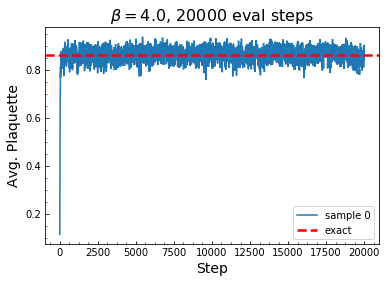

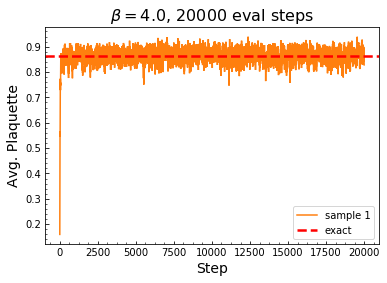

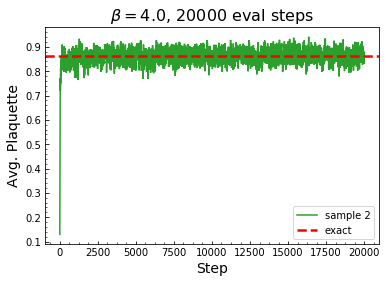

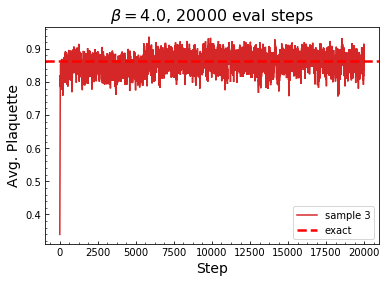

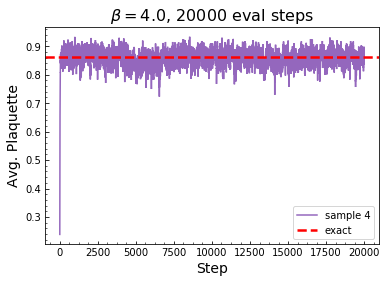

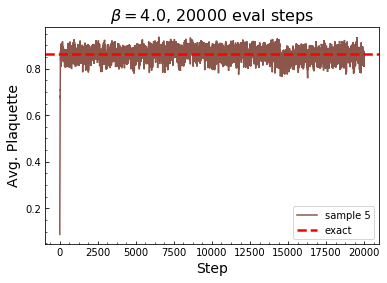

In [161]:
steps = np.arange(plaqs_arr.shape[0])
for idx in range(plaqs_arr.shape[1]):
    fig, ax = plt.subplots()
    _ = ax.plot(steps, plaqs_arr[:, idx], label=f'sample {idx}', marker='', color=COLORS[idx])
    _ = ax.axhline(y=u1_plaq_exact(4.), color='r', ls='--', lw=2.5, label='exact')
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Step', fontsize=14)
    _ = ax.set_ylabel('Avg. Plaquette', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{4.0}, {20000} eval steps")
    _ = ax.set_title(title_str, fontsize=16)
    out_file = os.path.join(log_dir, 'figures', f'avg_plaquette_sample{idx}.pdf')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')
    _ = plt.show()

Text(0.5, 0, 'Step')

Text(0, 0.5, 'Avg. Plaquette')

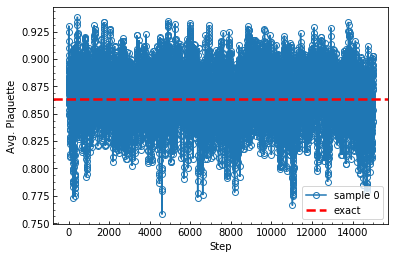

In [151]:
steps = np.arange(plaqs_arr.shape[0])
fig, ax = plt.subplots()
ax.plot(steps, plaqs_arr[:, 0], label='sample 0', marker='.', color='C0')
_ = ax.axhline(y=u1_plaq_exact(4.), color='r', ls='--', lw=2.5, label='exact')
ax.legend(loc='best')
ax.set_xlabel('Step')
ax.set_ylabel('Avg. Plaquette')
plt.show()

In [11]:
plot_observables(log_dir, observables_dicts, training=False)

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_226/figures/50000_steps_beta_3.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_226/figures/50000_steps_beta_3.0/avera

In [12]:
plot_top_charges(log_dir, observables_dicts[2], training=False)

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_history_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_cha

In [13]:
plt.close('all')
plot_top_charges_counts(log_dir, observables_dicts[2], training=False)

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_charge_cou

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_3.0/topological_charge_counts_total_20000_steps_beta_3.0.pdf.


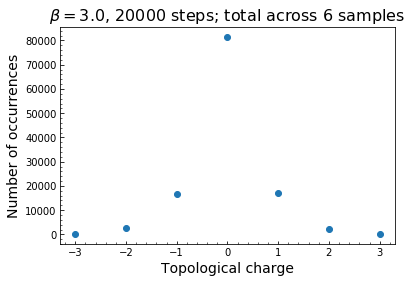

Saving figure to ../../gauge_logs_graph/run_226/figures/20000_steps_beta_4.0/topological_charge_counts_total_20000_steps_beta_4.0.pdf.


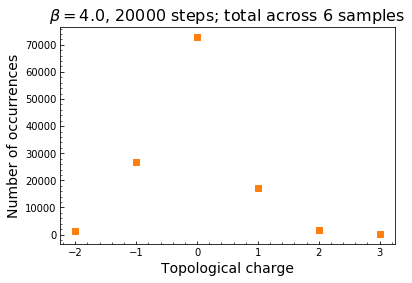

Saving figure to ../../gauge_logs_graph/run_226/figures/50000_steps_beta_3.0/topological_charge_counts_total_50000_steps_beta_3.0.pdf.


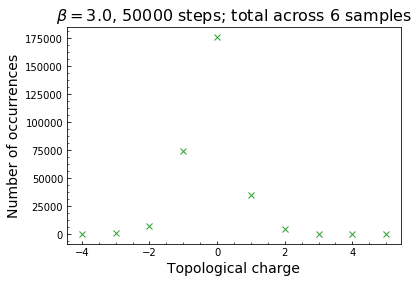

Saving figure to ../../gauge_logs_graph/run_226/figures/50000_steps_beta_4.0/topological_charge_counts_total_50000_steps_beta_4.0.pdf.


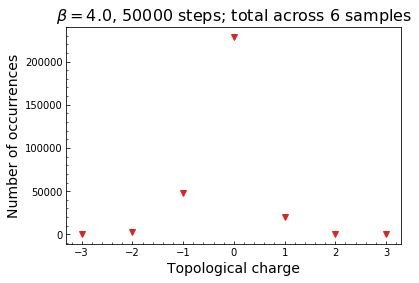

In [16]:
plt.close('all')
COLORS *= 10
MARKERS *= 10
params, _, _, _, figs_dir_dict = find_samples(log_dir)
charges_dict = observables_dicts[2]
title_str_key = 'evaluation'
count_dict = {}
idx = 0
for key, val in charges_dict.items():
    step, beta = key 
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='',
                fillstyle='full')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=16)
    #out_dir = os.path.join(
    #    figs_dir_dict[key], 'topological_charges_counts'
    #)
    #check_else_make_dir(out_dir)
    out_file = os.path.join(
       figs_dir_dict[key],
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close('all')

In [20]:
plt.close('all')

In [21]:
def update_beta(step, beta_init, beta_final, train_steps):
    """Returns new beta to follow annealing schedule."""
    temp = ((1. / beta_init - 1. / beta_final)
            * (1. - step / float(train_steps))
            + 1. / beta_final)
    new_beta = 1. / temp

    return new_beta

In [22]:
update_beta(500, 3., 4., 5000)

3.0769230769230775

In [90]:
def update_beta1(beta, annealing_factor, beta_final):
    new_beta = beta / annealing_factor
    if new_beta < beta_final:
        return new_beta
    return beta_final

In [83]:
def update_beta2(beta_init, beta_final, train_steps, step):
    """Returns new beta to follow annealing schedule."""
    temp = ((1. / beta_init - 1. / beta_final)
            * (1. - step / float(train_steps))
            + 1. / beta_final)
    new_beta = 1. / temp
    return new_beta

In [93]:
beta_init = 2.
beta_final = 4.
train_steps = 6931

In [94]:
betas1 = []
betas2 = []
beta1 = beta_init
for i in range(train_steps):
    beta1 = update_beta1(beta1, 0.9999, beta_final)
    beta2 = update_beta2(beta_init, beta_final, train_steps, i)
    betas1.append(beta1)
    betas2.append(beta2)
betas1 = np.array(betas1)
betas2 = np.array(betas2)

In [92]:
np.where(betas1 >= 4.)

(array([6931, 6932, 6933, ..., 9997, 9998, 9999]),)

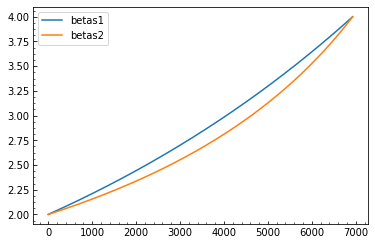

In [95]:
x = np.arange(train_steps)
fig, ax = plt.subplots()
ax.plot(x, betas1, label='betas1')
ax.plot(x, betas2, label='betas2')
ax.legend(loc='best')

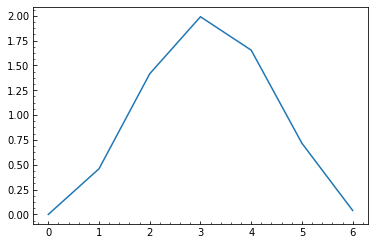

In [62]:
x = np.arange(0, 2* np.pi)
y = 1. - np.cos(x)
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

# OLD

### Topological susceptibility

$ \chi(\beta, V) \equiv \frac{\left< Q^2 \right>}{V}$

In [ ]:
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

In [ ]:
actions_dicts, plaqs_dicts, charges_dicts = observables_dicts
charges = charges_dicts[5000]

In [ ]:
test_statistic = lambda x: np.mean(x)

estimate_arr = []
bias_arr = []
stderr_arr = []
conf_interval_arr = []
for idx, sample in enumerate(charges.T):
    sample_squared = sample ** 2
    charge_rs = jackknife_resampling(sample_squared)
    estimate, bias, stderr, conf_interval = jackknife_stats(sample_squared,
                                                            test_statistic,
                                                            0.95)
    print(80 * '-' + '\n')
    print(f"Topological susceptibility statistics for sample {idx}, "
          f"consisting of {charge_rs.shape[0]} L2HMC steps.")
    print(f'estimate: {estimate}')
    print(f'bias: {bias}')
    print(f'stderr: {stderr}')
    print(f'conf_interval: {conf_interval}\n')
    print(80 * '-' + '\n')
    estimate_arr.append(estimate)
    bias_arr.append(bias)
    stderr_arr.append(stderr)
    conf_interval_arr.extend(conf_interval)

In [ ]:
test_statistic = lambda x: np.mean(x)

estimate_arr = []
bias_arr = []
stderr_arr = []
conf_interval_arr = []
for idx, sample in enumerate(charges.T):
    sample_squared = sample ** 2
    charge_rs = jackknife_resampling(sample_squared)
    estimate, bias, stderr, conf_interval = jackknife_stats(sample_squared,
                                                            test_statistic,
                                                            0.95)
    print(80 * '-' + '\n')
    print(f"Topological susceptibility statistics for sample {idx}, "
          f"consisting of {charge_rs.shape[0]} L2HMC steps.")
    print(f'estimate: {estimate}')
    print(f'bias: {bias}')
    print(f'stderr: {stderr}')
    print(f'conf_interval: {conf_interval}\n')
    print(80 * '-' + '\n')
    estimate_arr.append(estimate)
    bias_arr.append(bias)
    stderr_arr.append(stderr)
    conf_interval_arr.extend(conf_interval)

In [ ]:
charges_rs = np.array([jackknife_resampling(sample**2) for sample in charges.T])
charges_rs.shape

In [ ]:
test_statistic = lambda x: np.mean(x))

susceptibility_stats = {
    'estimate': [],
    'bias': [],
    'stderr': [],
    'conf_interval': []
}
for sample in charges_rs:
    estimate, bias, stderr, conf_interval = jackknife_stats(sample,
                                                            test_statistic,
                                                            0.95)
    susceptibility_stats['estimate'].append(estimate)
    susceptibility_stats['bias'].append(bias)
    susceptibility_stats['stderr'].append(bias)
    susceptibility_stats['conf_interval'].append(conf_interval)

In [ ]:
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(data, 
                                                        test_statistic, 
                                                        0.95)

In [ ]:
charge_squared_mean, charge_squared_err = resampling.jackknife(
    charges, func=lambda x: x**2, func_axis=0
)

In [ ]:
%debug

In [ ]:
squared_mean_a, squared_mean_a_error = resampling.jackknife(a, func=lambda x: x**2)


In [ ]:
suscept = []
errors = []
for sample in charges.T:
    charges_rs = block_resampling(np.array(sample), 2500)
    avg_charge2_rs = []
    for block in charges_rs:
        avg_charge2_rs.append(np.mean(block ** 2))
    error = jackknife_err(y_i=avg_charge2_rs,
                          y_full=sample,
                          num_blocks=2500)
    suscept.append(np.mean(avg_charge2_rs))
    errors.append(error)

In [ ]:
charges = charges_dicts[10000]
print(np.mean(charges**2, axis=0))

In [ ]:
from lattice.lattice import GaugeLattice

In [ ]:
lattice = GaugeLattice(4, 4, 2, 'U1', 5, rand=False, data_format='channels_last')

In [ ]:
lattice_gpu = GaugeLattice(4, 4, 2, 'U1', 5, rand=False, data_format='channels_first')

In [ ]:
lattice.links.shape, lattice_gpu.links.shape

In [ ]:
lattice.samples.shape, lattice_gpu.samples.shape

In [ ]:
for key in lattice.plaquettes_dict.keys():
    print(f'channels_last  {key}: {lattice.plaquettes_dict[key]}')
    print(f'channels_first {key}: {lattice_gpu.plaquettes_dict[key]}')
    print('\n')

In [ ]:
rand_samples = np.random.randn(lattice.num_samples * lattice.num_links)
rand_links = np.random.randn(lattice.num_links)

In [ ]:
s_rand = rand_samples.reshape(lattice.samples.shape)
l_rand = rand_links.reshape(lattice.links.shape)
s_rand.shape, l_rand.shape

In [ ]:
s_rand_gpu = s_rand.transpose(0, 3, 1, 2)
l_rand_gpu = l_rand.transpose(2, 0, 1)
s_rand_gpu.shape, l_rand_gpu.shape

In [ ]:
lattice._total_action(l_rand)

In [ ]:
lattice_gpu._total_action(l_rand_gpu)

In [ ]:
for key in lattice.plaquettes_dict.keys():
    idxs0 = lattice.plaquettes_dict[key]
    idxs1 = lattice_gpu.plaquettes_dict[key]
    plaq_sum0 = [l_rand[idxs0[0]] + l_rand[idxs0[1]] 
                 - l_rand[idxs0[2]] -  l_rand[idxs0[3]]]
    plaq_sum1 = [l_rand_gpu[idxs1[0]] + l_rand_gpu[idxs1[1]] 
                 - l_rand_gpu[idxs1[2]] - l_rand_gpu[idxs1[3]]]
    print(f'plaq_sum (channels last):  {plaq_sum0}')
    print(f'plaq_sum (channels first): {plaq_sum1}')
    print('\n')

In [ ]:
print(lattice.calc_plaq_observables(s_rand, 1.))

In [ ]:
print(lattice_gpu.calc_plaq_observables(s_rand_gpu, 1.))

In [ ]:
lattice._total_action(l_rand)

In [ ]:
lattice_gpu._total_action(l_rand_gpu)

In [ ]:
links_shape = tuple([8] + [8 for _ in range(1)] + [2])
links = np.arange(lattice.num_links).reshape(links_shape)
#links = np.zeros(links_shape, dtype=np.float32)

In [ ]:
plaquettes_arr = np.array(list(lattice.plaquettes_dict.values()))

In [ ]:
print(plaquettes_arr)

In [ ]:
plaquettes_arr.shape

In [ ]:
plaquettes_arr[0, 2:, :]

In [ ]:
pos_plaquettes = plaquettes_arr[:, :2, :]
neg_plaquettes = plaquettes_arr[:, 2:, :]

In [ ]:
action, plaqs, charge = lattice._calc_plaq_observables(links, beta=1.)

In [ ]:
charge

In [ ]:
def project_angle(x):
    return x - 2 * np.pi * tf.math.floor((x + np.pi) / (2 * np.pi))

In [ ]:
pos_plaquettes[0]
np.sum(pos_plaquettes[0], axis=1)
neg_plaquettes[0]

In [ ]:
links(pos_plaquettes[0])

In [ ]:
_charge = np.sum(project_angle(np.sum(links[pos_plaquettes]) - np.sum(links[neg_plaquettes])))

In [ ]:
_charge

In [ ]:
links[0][0]

In [ ]:
links[0, 1]

In [ ]:
links.shape

In [ ]:
links[]

In [ ]:
links

In [ ]:
links = np.array(
    [[i, j, k] for i in range(8) for j in range(8) for k in range(2)]
)
links
links.shape

In [ ]:
lattice.links.shape

In [ ]:
arr = np.array(
    [[a, b, c, d] for a in range(5) for b in range(8) for c in range(8) for d in range(2)]
).reshape(lattice.samples.shape)
arr
arr.shape

In [ ]:
patches = tf.extract_image_patches(images=samples_tensor,
                                   ksizes=[1, 2, 2, 1],
                                   strides=[1, 1, 1, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

In [ ]:
patches.shape

In [ ]:
patches[0, 

In [ ]:
  print tf.extract_image_patches(images=images, ksizes=[1, 3, 3, 1], strides=[1, 5, 5, 1], rates=[1, 1, 1, 1], padding='VALID').eval(), '\n\n'


In [ ]:
offsets = np.array(
    [(i, j) for i in range(8) for j in range(8)],  dtype=np.float32
)
offsets
offsets.shape

In [ ]:
samples_tensor = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
glimpse = tf.image.extract_glimpse(input=samples_tensor, size=(2, 2), offsets=offsets)

In [ ]:
samples_tensor.shape

## Using helpers from: `utils/gauge_observables.py`

In [ ]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

In [ ]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

In [ ]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [ ]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [ ]:
lattice.links.shape

## Calculate observables and create plots step by step, dir by dir...

In [ ]:
log_dir = '../../gauge_logs_graph/run_1/'
observables_dicts = calc_observables(log_dir)

In [ ]:
observables_dicts = calc_observables(log_dir, observables_dicts)

In [ ]:
figs_axes = plot_observables(log_dir, observables_dicts)

In [ ]:
plot_top_charges(log_dir, observables_dicts[-1])

In [ ]:
plt.close('all')

In [ ]:
batch_size = 5
forward_mask = tf.cast(
    tf.random_uniform((batch_size,)) > 0.5,
    tf.float32
)
backward_mask = 1. - forward_mask

In [ ]:
lattice = GaugeLattice(8, 8, 2, 'U1', batch_size, rand=False)
position = lattice.samples
position.shape

In [ ]:
position_mask_forward = forward_mask[:, None, None, None] * position

In [ ]:
position_mask_forward.shape

In [ ]:
forward_mask

In [ ]:
backward_mask

### OLD

In [ ]:
log_dir = (
    '../../gauge_logs_graph/run_78/'
)

figs_dir = os.path.join(log_dir, 'figures')
#autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
#check_else_make_dir(autocorr_dir)

#### Calculate observables

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

#### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [ ]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

#### Create plots

In [ ]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

In [ ]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    kwargs = {
        'figs_dir': _figs_dir
    }
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'], 
        _observables,
        **kwargs
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

In [ ]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], label=f'sample {idx}', 
                    color=COLORS[idx], marker=MARKERS[idx], fillstyle='none', 
                    ls=':', lw=0.75)
        _ = ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

In [ ]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def exp_fn(x, a, b, c, d):
    return a * np.exp(-b * (x - c))

In [ ]:
def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

In [ ]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

In [ ]:
ydata = actions[200][:, 0]
xdata = np.arange(len(ydata))

In [ ]:
A, K = fit_exp_linear(xdata, ydata, C=0)
#fit_y = model_func(t, A, K, C0)
plot(ax2, t, y, noisy_y, fit_y, (A0, K0, C0), (A, K, 0))
ax2.set_title('Linear Fit')

In [ ]:
popt, pcov = curve_fit(exp_fn, xdata, ydata)

In [ ]:
fig, ax = plt.subplots()
ax.plot(xdata, exp_fn(xdata, *popt), ls='-',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
ax.plot(xdata, ydata, marker='o', ls='', label='Sample 0')
ax.set_xlabel('Step')
ax.set_ylabel('Total action')
plt.show()

## Look at observables from samples generated during training 

In [ ]:
log_dir = '../../gauge_logs_graph/run_10/'
train_observables_dicts = calc_training_observables(log_dir)

In [ ]:
train_observables_dicts = calc_training_observables(log_dir, 
                                                    train_observables_dicts)

In [ ]:
figs_axes = plot_training_observables(log_dir, train_observables_dicts)

In [ ]:
#actions_dict, plaqs_dict, charges_dict = train_observables_dicts
plot_top_charges_training(log_dir, train_observables_dicts[-1])

### OLD

In [ ]:
from utils.gauge_observables import (
    _load_samples_from_file, _load_params, _calc_observables,
)

In [ ]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 50,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

In [ ]:
log_dir = '../../gauge_logs_graph/run_63/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 100,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

In [ ]:
log_dir = '../../gauge_logs_graph/run_78/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

#save_params_to_pkl_file(params, info_dir)

params = _load_params(log_dir)

figs_dir = os.path.join(log_dir, 'figures')
samples_dict, actions_dict, plaqs_dict, charges_dict = {}, {}, {}, {}

In [ ]:
train_samples_files = [train_samples_dir + i 
                       for i in os.listdir(train_samples_dir) 
                       if i.endswith('.pkl')]
train_samples_files

In [ ]:
step_keys = sorted(
    [int(i.split('/')[-1].split('_')[2]) for i in train_samples_files]
)
step_keys

In [ ]:
training_figs_dir = os.path.join(figs_dir, 'training/')
check_else_make_dir(training_figs_dir)
training_steps_figs_dir = {}

for key in step_keys:
    _dir = os.path.join(training_figs_dir, f'{key}_train_steps/')
    check_else_make_dir(_dir)
    training_steps_figs_dir[key] = _dir

In [ ]:
for idx, sample_file in enumerate(train_samples_files):
    step = step_keys[idx]
    if step not in charges_dict.keys():
        print(f"Calculating observables for {step}...")
        with open(sample_file, 'rb') as f:
            samples = pickle.load(f)

        actions, plaqs, charges = _calc_observables(samples, params)

        actions_dict[step] = actions
        plaqs_dict[step] = plaqs
        charges_dict[step] = charges

In [ ]:
for key in charges_dict.keys():
    actions = actions_dict[key]
    plaqs = plaqs_dict[key]
    charges = charges_dict[key]
    observables = (actions, plaqs, charges)
    
    title_str = (r"$\beta =$"
                 + f"{params['beta_final']}, {key} training steps")
    
    kwargs = {
        'figs_dir': training_steps_figs_dir[key],
        'title': title_str
    }
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'],  
        observables, 
        **kwargs
    )

In [ ]:
plt.close('all')
for key, val in charges_dict.items():
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], 
                    marker=MARKERS[idx], color=COLORS[idx], 
                    ls='', fillstyle='none', label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        title_str = (r"$\beta =$"
                     + f"{params['beta_final']}, {key} training steps")
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(training_steps_figs_dir[key],
                                f'topological_charge_history_sample_{idx}.pdf')
        if not os.path.isfile(out_file):
            print(f"Saving figure to: {out_file}.")
            _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
        
        #_ = ax.set_title(fr"""$\beta =$ {params['beta_final']},"""
        #                 fr""" {key} training steps""")
                         

## Modifying lattice structure

In [ ]:
from lattice.lattice import GaugeLattice

In [ ]:
lattice = GaugeLattice(8, 8, 2, 'U1', 5, False)

In [ ]:
lattice.links.shape

In [ ]:
sample = lattice.samples[0]

In [ ]:
sample

In [ ]:
lattice.sites

In [ ]:
links_arr = np.arange(lattice.num_links).reshape(sample.shape)
sites_arr = np.arange(lattice.num_sites).reshape(lattice.sites.shape)

In [ ]:
sites_arr = np.array(lattice.num_sites * ['o']).reshape(lattice.sites.shape)

In [ ]:
print(sites_arr)
print(sites_arr.shape)

In [ ]:
print(links_arr.T)
print(links_arr.T.shape)

In [ ]:
print(links_arr)

## OLD PLOTS

In [ ]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

In [ ]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

## OLD

In [ ]:
np.mean(ESS_arr)

In [ ]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [ ]:
lattice.num_links

##### Old approach (unsure of validity)

In [ ]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [ ]:
iac2, iac4, iac10

In [ ]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})